# Sorting (排序法)，Fama-MacBeth 回归

- [Sorting (排序法)，Fama-MacBeth 回归](#sorting-排序法fama-macbeth-回归)
  - [横截面多因子回归回顾](#横截面多因子回归回顾)
- [Data](#Data)
  - [Risk free rate](#Risk-free-rate)
  - [Beta](#Beta)
    - [ratio of available stocks](#ratio-of-available-stocks)
    - [distribution of beta](#distribution-of-beta)
      - [所有 beta 的分布](#所有-beta-的分布)
      - [个股 beta 的时间序列](#个股-beta-的时间序列)
        - [个股 beta 的时间序列方差](#个股-beta-的时间序列方差)
        - [随机看几个个股beta的时间序列](#随机看几个个股beta的时间序列)
    - [关于 beta 的观察总结](#关于-beta-的观察总结)
    - [Monthly beta](#Monthly-beta)
  - [Trading data](#trading-data)
  - [Merge data](#merge-data)
- [Sorting on Beta](#sorting-on-beta)
  - [return by portfolios](#return-by-portfolios)
    - [More robust by adjusting Newey-West Errors](#More-robust-by-adjusting-newey-west-errors)
  - [Portfolio characteristics other than return](#Portfolio-characteristics-other-than-return)
  - [beta 单排结论](#beta-单排结论)
- [Sorting on Market Capitalization](#Sorting-on-market-capitalization)
  - [The Size Effect](#The-size-effect)
  - [Distribution of Market Capitalization](#distribution-of-market-capitalization)
  - [Average return of porfolios sorted by market cap](#average-return-of-porfolios-sorted-by-market-cap)
    - [More robust by adjusting Newey-West errors](#more-robust-by-adjusting-newey-west-errors-1)
  - [Portfolio characteristics other than return](#portfolio-characteristics-other-than-return-1)
  - [Market Capitalization 单排结论](#market-capitalization-单排结论)
    - [Different time periods](#different-time-periods)
- [Double Sorting on Beta and Market Capitalization](#double-sorting-on-beta-and-market-capitalization)
    - [Beta, Market cap 双排结论](#beta-market-cap-双排结论)
- [Fama-MacBeth regression](#Fama-macbeth-regression)
  - [Without winsorization](#Without-winsorization)
  - [With winsorization](#With-winsorization)
- [结论](#结论)


## 横截面多因子回归回顾

$$R^e_{it+1} = \gamma_t + \lambda_{0t}\text{Anomaly}_{it} + \lambda_{1t} \beta_{it} + \lambda_{2t} Size_{it} + \lambda_{3t} BM_{it} + u_{it}  $$

In [67]:
import numpy as np
import pandas as pd
import datetime as dt

pd.set_option('display.max_rows', 20)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 9.0)
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import gc

In [68]:
plt.rcParams['figure.figsize'] = (16.0, 9.0)

# Data

In [69]:
START = '2007-01-01'
END = '2022-03-31'

In [70]:
DataAPI.SysCodeGet(codeTypeID=u"",valueCD='UN',field=u"",pandas="1")

codeTypeID valueCD           valueName
0       10005      UN                 未上市
1       30007      UN                 未评级
2       60008      UN  欧洲石脑油货物CIF西北（普氏）期货

In [71]:
stk_info = DataAPI.SecIDGet(assetClass="E",pandas="1")

In [72]:
stk_info['listStatusCD'].unique()

array(['L', 'DE', 'O', 'S', 'UN'], dtype=object)

In [73]:
# Security Id
stk_info = DataAPI.SecIDGet(assetClass="E",pandas="1")
cond1 = (stk_info['exchangeCD'] == 'XSHE') | (stk_info['exchangeCD'] == 'XSHG')
cond2 = (stk_info['listStatusCD'] == 'L') | (stk_info['listStatusCD'] == 'DE')
stk_info = stk_info[cond1 & cond2].copy()
stk_id = stk_info['secID']

## ST

In [74]:
st_df = DataAPI.SecSTGet(beginDate=START,endDate=END,secID=stk_id,field=['secID','tradeDate','STflg'],pandas="1")

In [75]:
st_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 513065 entries, 0 to 513064
Data columns (total 3 columns):
secID        513065 non-null object
tradeDate    513065 non-null object
STflg        513065 non-null object
dtypes: object(3)
memory usage: 11.7+ MB


In [76]:
st_df

secID   tradeDate STflg
0       000001.XSHE  2007-01-04     S
1       000001.XSHE  2007-01-05     S
2       000001.XSHE  2007-01-08     S
3       000001.XSHE  2007-01-09     S
4       000001.XSHE  2007-01-10     S
5       000001.XSHE  2007-01-11     S
6       000001.XSHE  2007-01-12     S
7       000001.XSHE  2007-01-15     S
8       000001.XSHE  2007-01-16     S
9       000001.XSHE  2007-01-17     S
...             ...         ...   ...
513055  900955.XSHG  2022-03-02   *ST
513056  900955.XSHG  2022-03-03   *ST
513057  900955.XSHG  2022-03-04   *ST
513058  900955.XSHG  2022-03-07   *ST
513059  900955.XSHG  2022-03-08   *ST
513060  900955.XSHG  2022-03-09   *ST
513061  900955.XSHG  2022-03-10   *ST
513062  900955.XSHG  2022-03-11   *ST
513063  900955.XSHG  2022-03-14   *ST
513064  900955.XSHG  2022-03-15   *ST

[513065 rows x 3 columns]

In [77]:
st_df['STflg'].unique()

array(['S', '*ST', 'ST', 'S*ST', 'SST', '*'], dtype=object)

In [78]:
st_df['tradeDate'] = pd.to_datetime(st_df['tradeDate'],format="%Y-%m-%d")

## Risk free rate

In [79]:
pd.read_csv("rf-monthly.csv").head()

日期_Date  年份_Year  月份_Month  月无风险收益率_MonRFRet  Unnamed: 4
0  1989-02-01     1989         2            0.0063         NaN
1  1989-03-01     1989         3            0.0063         NaN
2  1989-04-01     1989         4            0.0063         NaN
3  1989-05-01     1989         5            0.0063         NaN
4  1989-06-01     1989         6            0.0063         NaN

In [80]:
rf = pd.read_csv("rf-monthly.csv").drop(["Unnamed: 4", "年份_Year", "月份_Month"],axis=1)
rf.columns = ['Date', 'rf']
rf['Date'] = pd.to_datetime(rf["Date"])
rf['Date'] = rf['Date'].dt.to_period('M')
rf.rename(columns={'Date':'ym'},inplace=True)

In [81]:
rf

ym        rf
0    1989-02  0.006300
1    1989-03  0.006300
2    1989-04  0.006300
3    1989-05  0.006300
4    1989-06  0.006300
5    1989-07  0.006300
6    1989-08  0.006300
7    1989-09  0.006300
8    1989-10  0.006300
9    1989-11  0.006300
..       ...       ...
387  2021-05  0.002102
388  2021-06  0.002040
389  2021-07  0.002015
390  2021-08  0.001969
391  2021-09  0.001980
392  2021-10  0.002027
393  2021-11  0.002055
394  2021-12  0.002079
395  2022-01  0.002083
396  2022-02  0.002083

[397 rows x 2 columns]

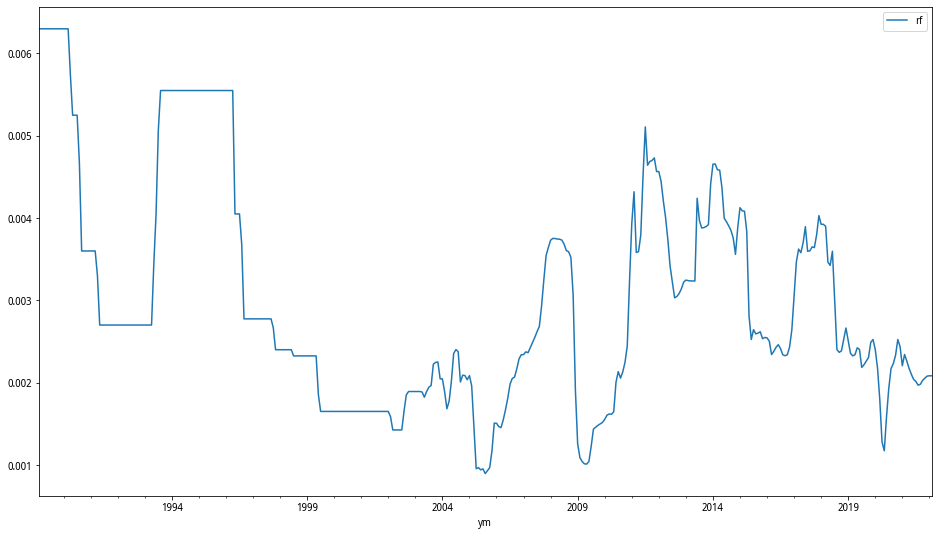

In [82]:
rf.set_index('ym').plot()

## Beta

Beta本身不是一个可以直接获取的公司特征，因此，需要计算：
- 用个股超额收益对市场超额收益回归，得到$\beta_i$的估计值
- 回归时间长度没有统一定论，有用过去一年的日收益率数据来算的，也有半年，2年，或者用月度的数据来算

计算量很大，因为涉及到几千只股票，每只个股要算比较长的一段时间（比如2007-2020有$14*12 = 168$个月，也即168个回归）。3000只股票，则回归的数目是 $168*3000 = 504,000$。
- 如果要自己用python计算，需要用到一些提速的技巧，比如用numpy array，或者参考这里：https://pandas.pydata.org/docs/user_guide/enhancingperf.html
- pandas进行大量数据操作的运算速度是一个比较重要的问题。没有统一或最好的解决方案。可以搜索以下关键词：dask, vaex, PySpark

因此，从实际操作的角度来讲，第一步的时序回归计算factor exposure本身计算量很大。因此，对于公司特征类因子，直接使用公司特征作为因子暴露，是一个经济上也合理的选择

In [83]:
# %time
# begin_ = 2007
# yesterday = dt.datetime.today() - dt.timedelta(days=1)
# yesterday.strftime('%Y%m%d')
# beta_df = DataAPI.MktStockFactorsDateRangeProGet(secID=stk_id,
#                                                      beginDate=f'{begin_}0101',
#                                                      endDate=yesterday,
#                                                      field=['secID','tradeDate','Beta60','Beta120','Beta252'],pandas="1")

In [84]:
# # # 从优矿下载 beta，时间较长。由于优矿的限制，每次下载3年的数据

# beta = {}
# begin_ = 2007
# end_ = 2010
# i = 0
# while end_ <= 2022:
#     if end_ == 2022:
#         yesterday = dt.datetime.today() - dt.timedelta(days=1)
#         yesterday.strftime('%Y%m%d')
#         beta[i] = DataAPI.MktStockFactorsDateRangeProGet(secID=stk_id,
#                                                      beginDate=f'{begin_}0101',
#                                                      endDate=yesterday,
#                                                      field=['secID','tradeDate','Beta60','Beta120','Beta252'],pandas="1")
#     else:
#         beta[i] = DataAPI.MktStockFactorsDateRangeProGet(secID=stk_id,
#                                                          beginDate=f'{begin_}0101',
#                                                          endDate=f'{end_}1231',
#                                                          field=['secID','tradeDate','Beta60','Beta120','Beta252'],pandas="1")
#     begin_ = end_ + 1
#     end_ = begin_ + 3
#     i = i+1
    
# for i in range(4):
#     beta_df = pd.DataFrame(np.vstack([_df for _df in beta.values()]),columns=['secID','tradeDate','Beta60','Beta120','Beta252'])
    
# beta_df.to_pickle('./data/beta_df.pkl')

In [85]:
beta_df = pd.read_pickle('./data/beta_df.pkl')

In [86]:
beta_df

secID   tradeDate  Beta60 Beta120 Beta252
0         000001.XSHE  2007-01-04  0.9418  1.0399  0.8756
1         000002.XSHE  2007-01-04  1.5191  1.3641   1.317
2         000004.XSHE  2007-01-04  0.7224  0.8521  0.6602
3         000006.XSHE  2007-01-04  1.4136  1.3265  1.2897
4         000007.XSHE  2007-01-04   0.949  0.7509   0.744
5         000008.XSHE  2007-01-04  0.6254  0.8338  0.7891
6         000005.XSHE  2007-01-04  0.9881  1.1183  0.7592
7         000009.XSHE  2007-01-04     NaN     NaN     NaN
8         000010.XSHE  2007-01-04     NaN     NaN     NaN
9         000011.XSHE  2007-01-04  0.2234  0.5498  0.2131
...               ...         ...     ...     ...     ...
10030609  688626.XSHG  2022-03-04  1.2895  1.0939  1.3572
10030610  688628.XSHG  2022-03-04  1.4885  1.2315  1.2217
10030611  688630.XSHG  2022-03-04  1.6096  1.8675  1.8141
10030612  688633.XSHG  2022-03-04   1.291  0.9885  0.9814
10030613  688690.XSHG  2022-03-04  1.5184  1.3751  2.8916
10030614  688696.XSHG  2022-03-04  0.9325  0.8997  1.6398
10030615  688697.XSHG  2022-03-04  0.4905  3.4612  1.9936
10030616  688698.XSHG  2022-03-04  1.0738  0.8039  0.9516
10030617  688699.XSHG  2022-03-04  1.2012  1.5869  1.1368
10030618  688700.XSHG  2022-03-04  1.2018  1.1771  0.5093

[10030619 rows x 5 columns]

In [87]:
beta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10030619 entries, 0 to 10030618
Data columns (total 5 columns):
secID        object
tradeDate    object
Beta60       object
Beta120      object
Beta252      object
dtypes: object(5)
memory usage: 382.6+ MB


In [88]:
beta_df.isna().sum()

secID             0
tradeDate         0
Beta60       490533
Beta120      490533
Beta252      693731
dtype: int64

In [89]:
beta_df['tradeDate'] = pd.to_datetime(beta_df['tradeDate'], format="%Y-%m-%d")

In [90]:
beta_df['ym'] = beta_df['tradeDate'].dt.to_period('M')

In [91]:
beta_df

secID  tradeDate  Beta60 Beta120 Beta252       ym
0         000001.XSHE 2007-01-04  0.9418  1.0399  0.8756  2007-01
1         000002.XSHE 2007-01-04  1.5191  1.3641   1.317  2007-01
2         000004.XSHE 2007-01-04  0.7224  0.8521  0.6602  2007-01
3         000006.XSHE 2007-01-04  1.4136  1.3265  1.2897  2007-01
4         000007.XSHE 2007-01-04   0.949  0.7509   0.744  2007-01
5         000008.XSHE 2007-01-04  0.6254  0.8338  0.7891  2007-01
6         000005.XSHE 2007-01-04  0.9881  1.1183  0.7592  2007-01
7         000009.XSHE 2007-01-04     NaN     NaN     NaN  2007-01
8         000010.XSHE 2007-01-04     NaN     NaN     NaN  2007-01
9         000011.XSHE 2007-01-04  0.2234  0.5498  0.2131  2007-01
...               ...        ...     ...     ...     ...      ...
10030609  688626.XSHG 2022-03-04  1.2895  1.0939  1.3572  2022-03
10030610  688628.XSHG 2022-03-04  1.4885  1.2315  1.2217  2022-03
10030611  688630.XSHG 2022-03-04  1.6096  1.8675  1.8141  2022-03
10030612  688633.XSHG 2022-03-04   1.291  0.9885  0.9814  2022-03
10030613  688690.XSHG 2022-03-04  1.5184  1.3751  2.8916  2022-03
10030614  688696.XSHG 2022-03-04  0.9325  0.8997  1.6398  2022-03
10030615  688697.XSHG 2022-03-04  0.4905  3.4612  1.9936  2022-03
10030616  688698.XSHG 2022-03-04  1.0738  0.8039  0.9516  2022-03
10030617  688699.XSHG 2022-03-04  1.2012  1.5869  1.1368  2022-03
10030618  688700.XSHG 2022-03-04  1.2018  1.1771  0.5093  2022-03

[10030619 rows x 6 columns]

In [92]:
beta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10030619 entries, 0 to 10030618
Data columns (total 6 columns):
secID        object
tradeDate    datetime64[ns]
Beta60       object
Beta120      object
Beta252      object
ym           period[M]
dtypes: datetime64[ns](1), object(4), period[M](1)
memory usage: 459.2+ MB


In [93]:
beta_df[['Beta60','Beta120','Beta252']] = beta_df[['Beta60','Beta120','Beta252']].apply(pd.to_numeric)

做以下观察：
1. 每月缺失值股票数占总股票数的比例
2. beta的时间序列变化是否比较大？

### ratio of available stocks

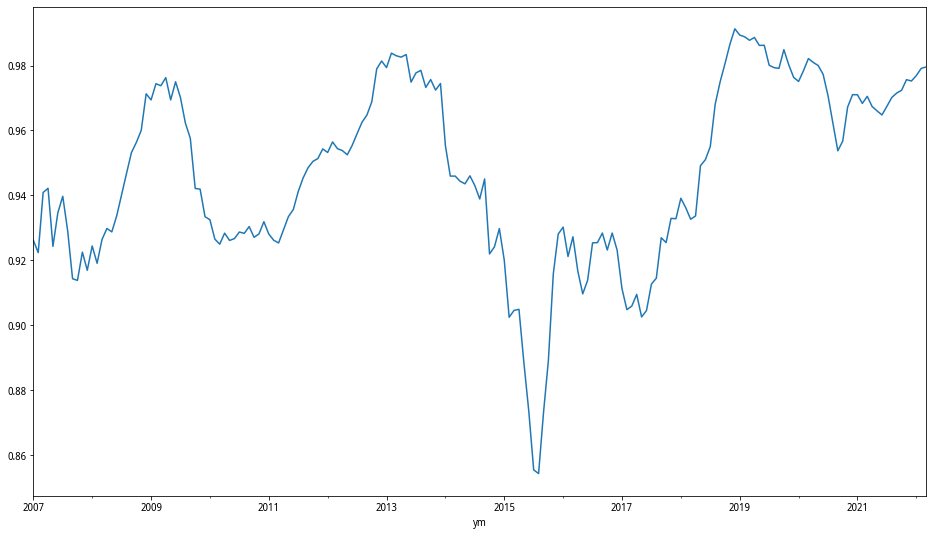

In [94]:
n_stk_avail = beta_df[['secID','tradeDate','ym','Beta252']].dropna().groupby('ym')['secID'].nunique()

n_stk = beta_df[['secID','tradeDate','ym','Beta252']].groupby('ym')['secID'].nunique()

(n_stk_avail / n_stk).plot()

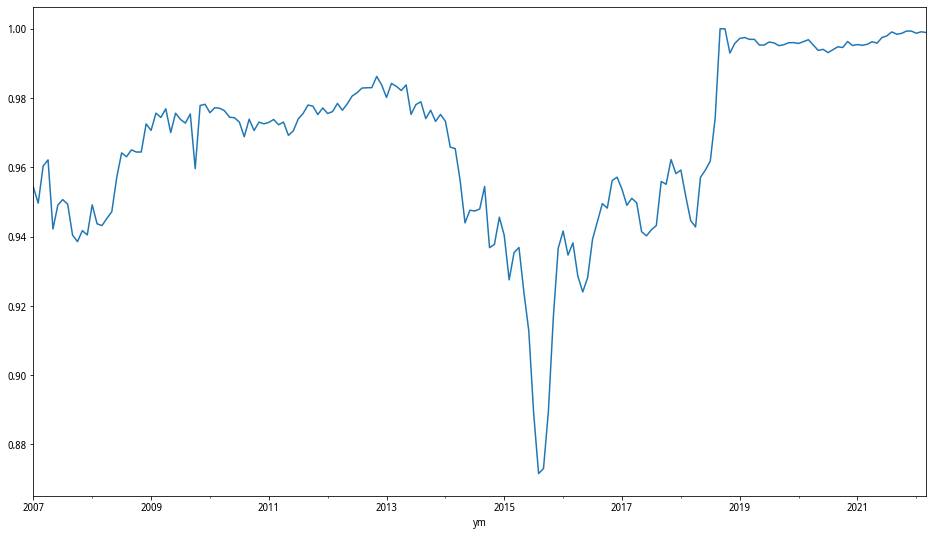

In [95]:
n_stk_avail = beta_df[['secID','tradeDate','ym','Beta60']].dropna().groupby('ym')['secID'].nunique()

n_stk = beta_df[['secID','tradeDate','ym','Beta60']].groupby('ym')['secID'].nunique()

(n_stk_avail / n_stk).plot()

### distribution of beta

#### 所有 beta 的分布

In [96]:
beta_df[['Beta60','Beta120','Beta252']].describe().round(2)

Beta60     Beta120     Beta252
count  9540086.00  9540086.00  9336888.00
mean         0.93        0.93        0.91
std         10.30       10.29        0.36
min     -13593.82   -13593.82      -19.31
25%          0.67        0.71        0.70
50%          0.96        0.97        0.95
75%          1.22        1.19        1.15
max      13062.15    13062.15       13.38

In [97]:
beta_df[['Beta60','Beta120','Beta252']].min()

Beta60    -13593.8244
Beta120   -13593.8244
Beta252      -19.3085
dtype: float64

In [98]:
beta_df[['Beta60','Beta120','Beta252']].max()

Beta60     13062.1548
Beta120    13062.1548
Beta252       13.3842
dtype: float64

In [99]:
beta_df['Beta60'].quantile(0.99)

2.0859

In [100]:
beta_df['Beta60'].quantile(0.9999)

24.901173699922488

In [101]:
beta_df['Beta60'].quantile(1e-4)

-29.030589799999998

In [102]:
beta_df['Beta60'].quantile(0.99999)

274.27078250021714

In [103]:
beta_df['Beta60'].quantile(1e-5)

-309.806471515

In [104]:
beta_df['Beta60'].nlargest(20)

730319     13062.1548
1775172    10307.0733
3557768     5701.1917
6786882     3613.6436
612991      3559.2241
730316      2921.0906
730317      2895.1891
612993      2817.7203
612990      2548.1984
524511      2537.8764
9891900     2481.2585
524507      2139.9478
2875460     1992.2528
530996      1964.6643
612985      1654.0531
2875468     1495.0415
148890      1370.3560
730318      1290.9675
9924743     1267.8620
5704941     1208.7913
Name: Beta60, dtype: float64

In [105]:
beta_df['Beta60'].nsmallest(20)

9943514   -13593.8244
5653828   -11659.9526
3914570    -6530.5735
9968347    -5320.1502
6746828    -4767.6606
5126179    -4761.6744
5706311    -4760.4127
8684631    -3237.3332
1628676    -3064.6110
521207     -2859.5471
182762     -2692.6698
231790     -2570.3014
231873     -2398.7193
5121995    -2033.9017
6917518    -2033.0892
6784172    -2031.6253
5658216    -2031.4281
5704479    -2030.0479
6781942    -1990.9044
231967     -1491.3523
Name: Beta60, dtype: float64

In [106]:
# beta_df[beta_df['Beta60'] == beta_df['Beta60'].min()]
beta_df.loc[[beta_df['Beta60'].idxmin()]]

secID  tradeDate      Beta60     Beta120  Beta252       ym
9943514  688112.XSHG 2021-12-02 -13593.8244 -13593.8244      NaN  2021-12

In [107]:
beta_df.loc[[beta_df['Beta60'].idxmax()]]

secID  tradeDate      Beta60     Beta120  Beta252       ym
730319  002499.XSHE 2010-11-10  13062.1548  13062.1548      NaN  2010-11

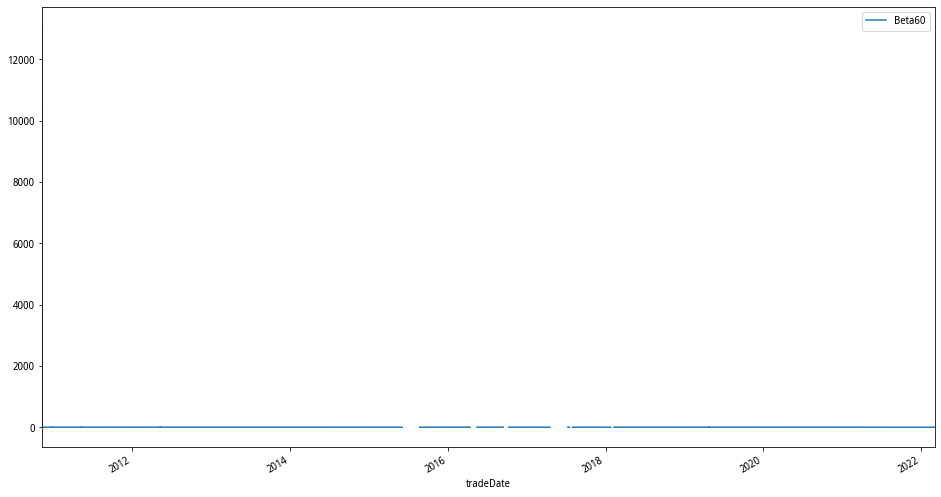

In [108]:
beta_df.loc[beta_df['secID']=='002499.XSHE',['Beta60','tradeDate']].set_index('tradeDate').plot()

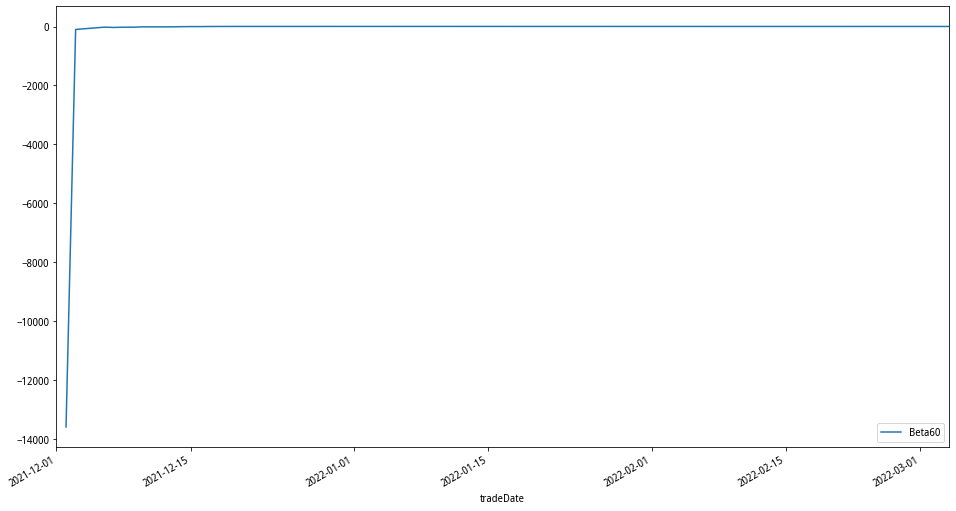

In [109]:
beta_df.loc[beta_df['secID']=='688112.XSHG',['Beta60','tradeDate']].set_index('tradeDate').plot()

#### 个股 beta 的时间序列

##### 个股 beta 的时间序列方差

In [110]:
num_cols = beta_df.select_dtypes(np.number).columns

In [111]:
beta_df.groupby('secID')[num_cols].var().describe().round(2)

Beta60     Beta120  Beta252
count     4741.00     4741.00  4653.00
mean       872.25      872.26     0.14
std      44557.52    44557.68     0.51
min          0.03        0.02     0.00
25%          0.18        0.13     0.07
50%          0.37        0.30     0.10
75%          1.76        1.72     0.13
max    3028749.16  3028760.86    20.89

In [112]:
# # Winsorization
# beta_df.loc[beta_df['Beta60'] > beta_df['Beta60'].quantile(0.99999),'Beta60'] = beta_df['Beta60'].quantile(0.99999)
# beta_df.loc[beta_df['Beta60'] < beta_df['Beta60'].quantile(0.00001),'Beta60'] = beta_df['Beta60'].quantile(0.00001)
# beta_df.loc[beta_df['Beta120'] > beta_df['Beta120'].quantile(0.99999),'Beta120'] = beta_df['Beta120'].quantile(0.99999)
# beta_df.loc[beta_df['Beta120'] < beta_df['Beta120'].quantile(0.00001),'Beta120'] = beta_df['Beta120'].quantile(0.00001)
beta_df['Beta60_winsor'] = beta_df['Beta60'].clip(lower=beta_df['Beta60'].quantile(0.00001),upper=beta_df['Beta60'].quantile(0.99999))
beta_df['Beta120_winsor'] = beta_df['Beta120'].clip(lower=beta_df['Beta120'].quantile(0.00001),upper=beta_df['Beta120'].quantile(0.99999))

In [113]:
num_cols = beta_df.select_dtypes(np.number).columns

In [114]:
beta_df.groupby('secID')[['Beta60_winsor','Beta120_winsor','Beta252']].var().describe().round(2)

Beta60_winsor  Beta120_winsor  Beta252
count        4741.00         4741.00  4653.00
mean           19.02           19.03     0.14
std           184.33          184.19     0.51
min             0.03            0.02     0.00
25%             0.18            0.13     0.07
50%             0.37            0.30     0.10
75%             1.76            1.72     0.13
max          5075.76         5058.07    20.89

##### 随机看几个个股beta的时间序列

In [115]:
stk_id_beta = beta_df['secID'].unique()

In [116]:
stk_picked = np.random.choice(stk_id_beta, 10)
print(stk_picked)
beta_plot = beta_df.loc[beta_df['secID'].isin(stk_picked)]

['300708.XSHE' '688520.XSHG' '300622.XSHE' '300813.XSHE' '000533.XSHE'
 '600873.XSHG' '301091.XSHE' '600666.XSHG' '002540.XSHE' '603050.XSHG']


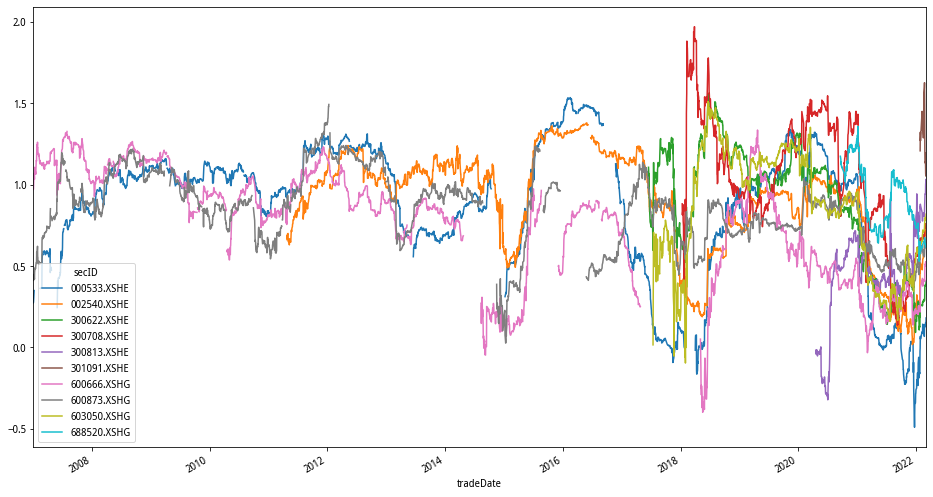

In [117]:
beta_plot.pivot(index='tradeDate', columns='secID', values='Beta252').plot()

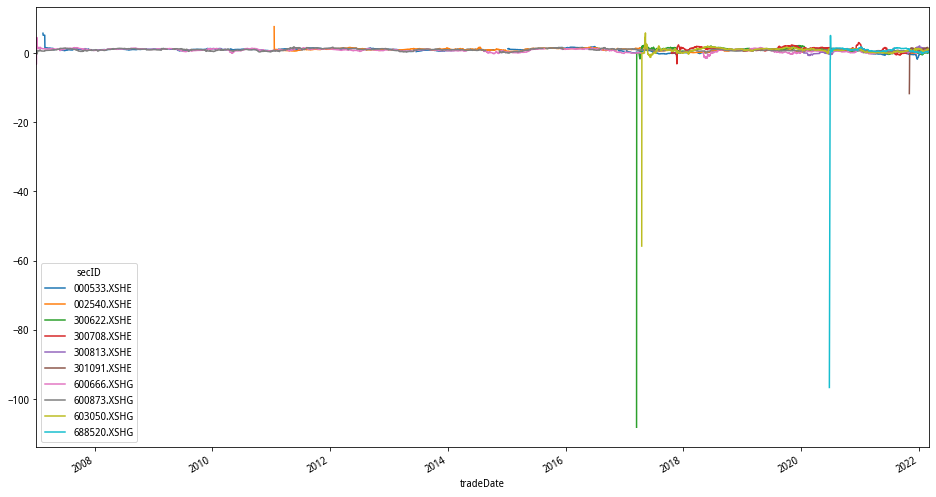

In [118]:
beta_plot.pivot(index='tradeDate', columns='secID', values='Beta60').plot()

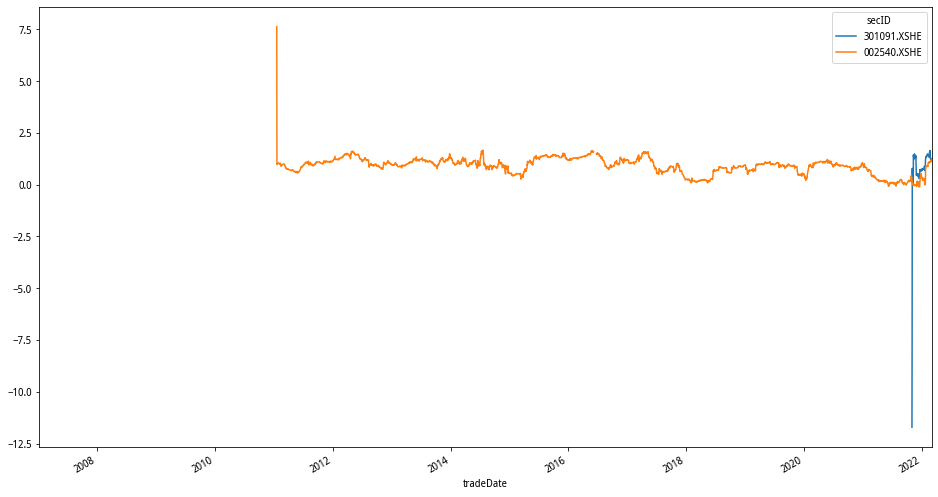

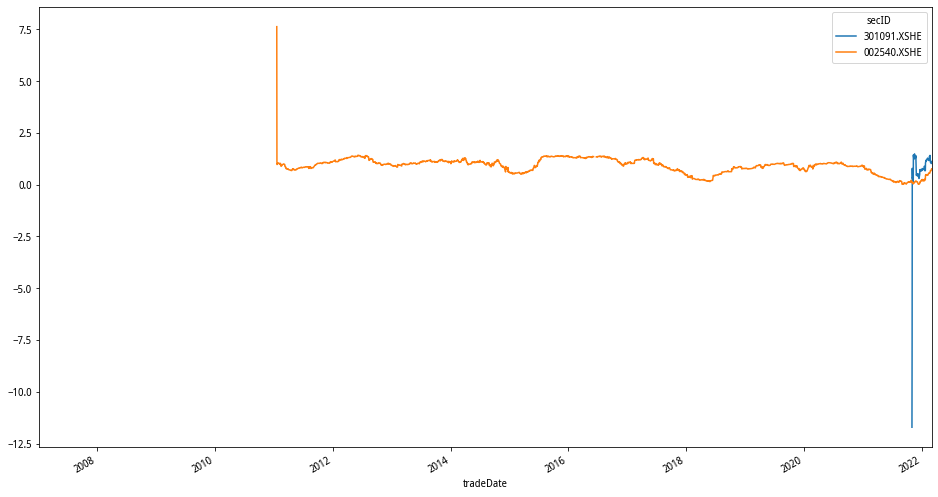

In [119]:
stk_ = np.random.choice(stk_picked,2)
beta_plot.pivot(index='tradeDate', columns='secID', values='Beta60')[[stk_[0],stk_[1]]].plot()
beta_plot.pivot(index='tradeDate', columns='secID', values='Beta120')[[stk_[0],stk_[1]]].plot()

In [120]:
beta_corr = beta_df.groupby('secID')[['Beta60','Beta120','Beta252']].corr()
beta_corr

Beta60   Beta120   Beta252
secID                                            
000001.XSHE Beta60   1.000000  0.898668  0.817103
            Beta120  0.898668  1.000000  0.878258
            Beta252  0.817103  0.878258  1.000000
000002.XSHE Beta60   1.000000  0.683876  0.598926
            Beta120  0.683876  1.000000  0.771350
            Beta252  0.598926  0.771350  1.000000
000004.XSHE Beta60   1.000000  0.769815  0.831099
            Beta120  0.769815  1.000000  0.878364
            Beta252  0.831099  0.878364  1.000000
000005.XSHE Beta60   1.000000  0.879389  0.823510
...                       ...       ...       ...
688800.XSHG Beta252  0.722584  0.787193  1.000000
688819.XSHG Beta60   1.000000  0.764282  0.899289
            Beta120  0.764282  1.000000  0.772850
            Beta252  0.899289  0.772850  1.000000
688981.XSHG Beta60   1.000000  0.837988  0.843624
            Beta120  0.837988  1.000000  0.948958
            Beta252  0.843624  0.948958  1.000000
689009.XSHG Beta60   1.000000  0.957938  0.923231
            Beta120  0.957938  1.000000  0.949009
            Beta252  0.923231  0.949009  1.000000

[14247 rows x 3 columns]

In [121]:
beta_corr['Beta252'].min()

-0.9010573257765621

In [122]:
beta_corr.loc[[beta_corr['Beta252'].idxmin()]]

Beta60   Beta120   Beta252
secID                                         
301155.XSHE Beta60     1.0  0.999988 -0.901057

In [123]:
beta_corr.loc['301155.XSHE']

Beta60   Beta120   Beta252
Beta60   1.000000  0.999988 -0.901057
Beta120  0.999988  1.000000  0.992863
Beta252 -0.901057  0.992863  1.000000

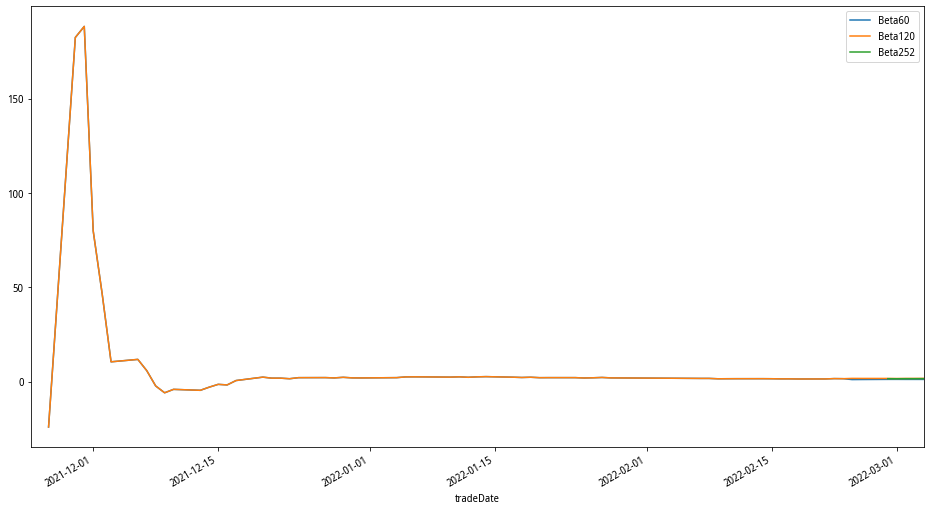

In [124]:
beta_df.loc[beta_df['secID']=='301155.XSHE',['tradeDate','Beta60','Beta120','Beta252']].set_index('tradeDate').plot()

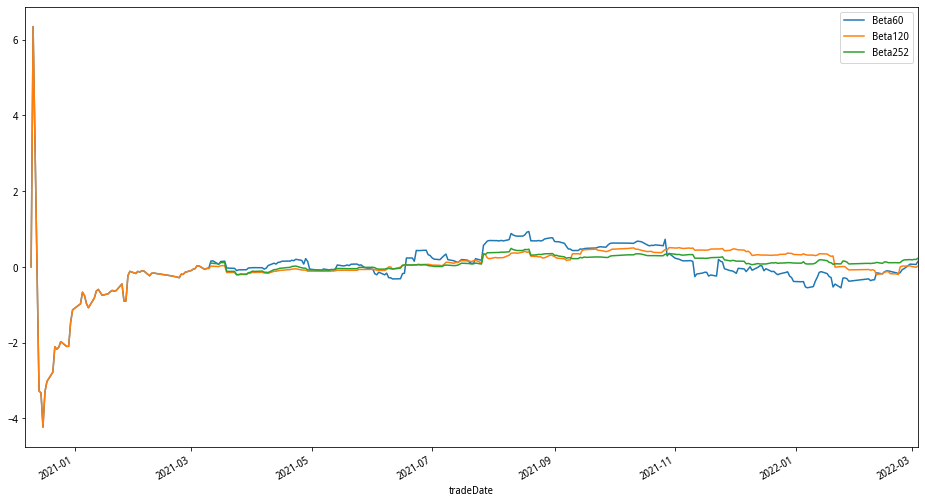

In [125]:
beta_df.loc[beta_df['secID']=='605183.XSHG',['tradeDate','Beta60','Beta120','Beta252']].set_index('tradeDate').plot()

In [126]:
beta_corr.loc[pd.IndexSlice[:,['Beta60','Beta120']],'Beta252'].mean()

0.8257999823547193

### 关于 beta 的观察总结

- 对于个股来讲，beta的时间序列变化很大
- Beta60, Beta120在初始估计时方差很大
- Beta252 比其他两个估计值要更稳定

### Monthly beta

In [127]:
beta_df.groupby(['secID','ym'])['Beta252'].last()

secID        ym     
000001.XSHE  2007-01    0.7949
             2007-02    0.7880
             2007-03    0.8512
             2007-04    0.8642
             2007-05    0.7715
             2007-06    0.4614
             2007-07    0.6423
             2007-08    0.7722
             2007-09    0.7596
             2007-10    0.7988
                         ...  
689009.XSHG  2021-06    1.3761
             2021-07    1.0975
             2021-08    1.0727
             2021-09    1.0100
             2021-10    0.8570
             2021-11    0.7546
             2021-12    0.5898
             2022-01    0.5326
             2022-02    0.5294
             2022-03    0.5710
Name: Beta252, Length: 501242, dtype: float64

In [128]:
beta_m_df = beta_df.groupby(['secID','ym'],as_index=False)['Beta252'].last()

In [129]:
beta_m_df

secID       ym  Beta252
0       000001.XSHE  2007-01   0.7949
1       000001.XSHE  2007-02   0.7880
2       000001.XSHE  2007-03   0.8512
3       000001.XSHE  2007-04   0.8642
4       000001.XSHE  2007-05   0.7715
5       000001.XSHE  2007-06   0.4614
6       000001.XSHE  2007-07   0.6423
7       000001.XSHE  2007-08   0.7722
8       000001.XSHE  2007-09   0.7596
9       000001.XSHE  2007-10   0.7988
...             ...      ...      ...
501232  689009.XSHG  2021-06   1.3761
501233  689009.XSHG  2021-07   1.0975
501234  689009.XSHG  2021-08   1.0727
501235  689009.XSHG  2021-09   1.0100
501236  689009.XSHG  2021-10   0.8570
501237  689009.XSHG  2021-11   0.7546
501238  689009.XSHG  2021-12   0.5898
501239  689009.XSHG  2022-01   0.5326
501240  689009.XSHG  2022-02   0.5294
501241  689009.XSHG  2022-03   0.5710

[501242 rows x 3 columns]

## Trading data

In [130]:
# stk_df = DataAPI.MktEqudAdjAfGet(secID=stk_id,beginDate=START,endDate=END,isOpen=1,
#                                            field=["secID","tradeDate",
#                                                   "closePrice",
#                                                   "negMarketValue"],pandas="1")

# stk_df.to_pickle('./data/stk_df.pkl')

In [131]:
stk_df = pd.read_pickle('./data/stk_df.pkl')

In [132]:
stk_df

secID   tradeDate  preClosePrice  closePrice  negMarketValue  \
0        000001.XSHE  2007-01-04        415.687     405.345    1.988610e+10   
1        000001.XSHE  2007-01-05        405.345     375.182    1.840627e+10   
2        000001.XSHE  2007-01-08        375.182     384.087    1.884317e+10   
3        000001.XSHE  2007-01-09        384.087     396.440    1.944920e+10   
4        000001.XSHE  2007-01-10        396.440     404.484    1.984382e+10   
5        000001.XSHE  2007-01-11        404.484     424.593    2.083037e+10   
6        000001.XSHE  2007-01-12        424.593     445.851    2.187330e+10   
7        000001.XSHE  2007-01-15        445.851     468.259    2.297260e+10   
8        000001.XSHE  2007-01-16        468.259     488.943    2.398734e+10   
9        000001.XSHE  2007-01-17        488.943     488.943    2.398734e+10   
...              ...         ...            ...         ...             ...   
9934180  900957.XSHG  2022-03-01          0.615       0.616    1.124240e+08   
9934181  900957.XSHG  2022-03-02          0.616       0.610    1.113200e+08   
9934182  900957.XSHG  2022-03-03          0.610       0.614    1.120560e+08   
9934183  900957.XSHG  2022-03-04          0.614       0.611    1.115040e+08   
9934184  900957.XSHG  2022-03-07          0.611       0.605    1.104000e+08   
9934185  900957.XSHG  2022-03-08          0.605       0.604    1.102160e+08   
9934186  900957.XSHG  2022-03-09          0.604       0.600    1.094800e+08   
9934187  900957.XSHG  2022-03-10          0.600       0.605    1.104000e+08   
9934188  900957.XSHG  2022-03-11          0.605       0.606    1.105840e+08   
9934189  900957.XSHG  2022-03-14          0.606       0.594    1.083760e+08   

         turnoverValue  turnoverRate  
0         1.016723e+09        0.0491  
1         7.150110e+08        0.0381  
2         4.218194e+08        0.0225  
3         6.504102e+08        0.0340  
4         6.190032e+08        0.0317  
5         5.993505e+08        0.0291  
6         1.399725e+09        0.0645  
7         8.736827e+08        0.0392  
8         8.930961e+08        0.0373  
9         7.790584e+08        0.0326  
...                ...           ...  
9934180   1.150660e+05        0.0010  
9934181   1.003980e+05        0.0009  
9934182   4.576100e+04        0.0004  
9934183   3.987800e+04        0.0004  
9934184   1.825430e+05        0.0016  
9934185   1.612110e+05        0.0015  
9934186   1.285010e+05        0.0012  
9934187   7.845200e+04        0.0007  
9934188   7.993400e+04        0.0007  
9934189   1.005700e+05        0.0009  

[9934190 rows x 7 columns]

In [133]:
stk_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9934190 entries, 0 to 9934189
Data columns (total 7 columns):
secID             object
tradeDate         object
preClosePrice     float64
closePrice        float64
negMarketValue    float64
turnoverValue     float64
turnoverRate      float64
dtypes: float64(5), object(2)
memory usage: 530.5+ MB


In [134]:
stk_df['tradeDate'] = pd.to_datetime(stk_df['tradeDate'], format='%Y-%m-%d')

In [135]:
stk_df['ym'] = stk_df['tradeDate'].dt.to_period('M')

In [136]:
stk_df.sort_values(['secID','tradeDate'],inplace=True)

### Exclude ST

In [137]:
st_df['tradeDate'] = pd.to_datetime(st_df['tradeDate'], format='%Y-%m-%d')

In [138]:
stk_df.dropna().shape

(9934190, 8)

In [139]:
stk_df.shape

(9934190, 8)

In [140]:
stk_df = pd.merge(stk_df, st_df, on=['secID','tradeDate'],how='left')

In [141]:
stk_df = stk_df[stk_df['STflg'].isna()].copy()

In [142]:
stk_df.drop('STflg',axis=1,inplace=True)

In [148]:
stk_df.shape

(9535739, 8)

### Monthly trading data

In [143]:
stk_df_m = stk_df.groupby(['secID','ym'],as_index=False).last() 
# 有些数据库会把没有当月最后一个交易日数据的股票的月收益率设为空值。这里不做此设置，只要当月任何一日有交易，
# 都可被提出。last()会把最后一个非空值提出。

In [144]:
from myutils import utils as ut
temp = ut.makeStockFrame()

In [145]:
temp

date variable     value
0  2000-01-03        A  0.587314
1  2000-01-04        A -1.801787
2  2000-01-05        A -0.312262
3  2000-01-03        B -0.432028
4  2000-01-04        B  0.909185
5  2000-01-05        B -0.376762
6  2000-01-03        C -0.044881
7  2000-01-04        C  1.265041
8  2000-01-05        C -0.032814
9  2000-01-03        D  1.539870
10 2000-01-04        D  1.104861
11 2000-01-05        D  0.604129

In [146]:
temp.loc[5,'date'] = np.nan

In [147]:
temp.drop(5).groupby('variable').last()

date     value
variable                     
A        2000-01-05 -0.312262
B        2000-01-04  0.909185
C        2000-01-05 -0.032814
D        2000-01-05  0.604129

#### Fill na months

In [150]:
stk_df_m[(stk_df_m['secID']=='000001.XSHE') & (stk_df_m['tradeDate']>='2010-05') & (stk_df_m['tradeDate']<='2010-10')]

secID       ym  tradeDate  preClosePrice  closePrice  \
35  000001.XSHE  2010-05 2010-05-31        745.994     722.475   
36  000001.XSHE  2010-06 2010-06-29        762.910     722.475   
37  000001.XSHE  2010-09 2010-09-29        670.899     669.249   

    negMarketValue  turnoverValue  turnoverRate  
35    5.120124e+10    480683776.0        0.0092  
36    5.437499e+10    549134850.0        0.0099  
37    5.036906e+10    347260768.0        0.0069

In [154]:
np.where(full_dates == )

NameError: name 'Period' is not defined

In [155]:
def fill_missing(df, full_dates, id_col='secID', date_col='ym'):
    """
    This function fills the missing dates for stocks.
    Parameters:
        df: The dataframe. Could be a sub-dataframe created by "groupby".
            The dataframe must be sorted on the "date_col".
        full_dates: the unique dates covering all securities in the full dataframe. 
                    Need to be sorted.
        id_col: the security id.
        date_col: the dates column for the security
    Returns:
        A dataframe with the missing dates filled with NA.
    """
    one_stk_id = df[id_col].unique()
    date_start = np.where(full_dates == df[date_col].min())[0][0] 
    date_end = np.where(full_dates == df[date_col].max())[0][0]
    dates = full_dates[date_start:date_end+1]
    idx = pd.MultiIndex.from_product([one_stk_id,dates],
                                     names=(id_col,date_col))
    df = df.set_index([id_col,date_col]).reindex(idx).reset_index()
    return df

In [151]:
full_dates = np.sort(stk_df['ym'].unique())

In [152]:
full_dates

array([Period('2007-01', 'M'), Period('2007-02', 'M'),
       Period('2007-03', 'M'), Period('2007-04', 'M'),
       Period('2007-05', 'M'), Period('2007-06', 'M'),
       Period('2007-07', 'M'), Period('2007-08', 'M'),
       Period('2007-09', 'M'), Period('2007-10', 'M'),
       Period('2007-11', 'M'), Period('2007-12', 'M'),
       Period('2008-01', 'M'), Period('2008-02', 'M'),
       Period('2008-03', 'M'), Period('2008-04', 'M'),
       Period('2008-05', 'M'), Period('2008-06', 'M'),
       Period('2008-07', 'M'), Period('2008-08', 'M'),
       Period('2008-09', 'M'), Period('2008-10', 'M'),
       Period('2008-11', 'M'), Period('2008-12', 'M'),
       Period('2009-01', 'M'), Period('2009-02', 'M'),
       Period('2009-03', 'M'), Period('2009-04', 'M'),
       Period('2009-05', 'M'), Period('2009-06', 'M'),
       Period('2009-07', 'M'), Period('2009-08', 'M'),
       Period('2009-09', 'M'), Period('2009-10', 'M'),
       Period('2009-11', 'M'), Period('2009-12', 'M'),
       Per

#### Example

In [156]:
x = ['a','b','c']
y = full_dates[0:3]

In [157]:
idx = pd.MultiIndex.from_product([x, y])
idx

MultiIndex(levels=[['a', 'b', 'c'], [2007-01, 2007-02, 2007-03]],
           codes=[[0, 0, 0, 1, 1, 1, 2, 2, 2], [0, 1, 2, 0, 1, 2, 0, 1, 2]])

In [158]:
temp = pd.DataFrame({'x':['a','a','b','c'],'y':[full_dates[0],full_dates[1],full_dates[1],full_dates[2]],'value':[1,2,3,4]}).set_index(['x','y'])

In [159]:
temp

value
x y             
a 2007-01      1
  2007-02      2
b 2007-02      3
c 2007-03      4

In [161]:
temp.reindex(idx).reset_index()

level_0  level_1  value
0       a  2007-01    1.0
1       a  2007-02    2.0
2       a  2007-03    NaN
3       b  2007-01    NaN
4       b  2007-02    3.0
5       b  2007-03    NaN
6       c  2007-01    NaN
7       c  2007-02    NaN
8       c  2007-03    4.0

In [162]:
temp = stk_df_m[stk_df_m['secID']=='300432.XSHE'].copy()

In [163]:
date_start = np.where(full_dates == temp['ym'].min())[0][0]
date_end = np.where(full_dates == temp['ym'].max())[0][0]

In [164]:
dates = full_dates[date_start:date_end+1]

In [165]:
len(dates)

85

In [166]:
temp['ym'].shape

(82,)

In [167]:
np.setdiff1d(dates,temp['ym'])

array([Period('2016-03', 'M'), Period('2016-04', 'M'),
       Period('2016-05', 'M')], dtype=object)

In [168]:
one_stk_id = temp['secID'].unique()

In [169]:
idx = pd.MultiIndex.from_product([one_stk_id, dates],names=('secID','ym'))
temp = temp.set_index(['secID','ym']).reindex(idx)

In [170]:
temp

tradeDate  preClosePrice  closePrice  negMarketValue  \
secID       ym                                                              
300432.XSHE 2015-03 2015-03-31         39.200      43.120    1.293600e+09   
            2015-04 2015-04-30         59.790      62.510    1.875300e+09   
            2015-05 2015-05-29         91.983      94.290    2.820000e+09   
            2015-06 2015-06-30         84.821      86.265    2.580000e+09   
            2015-07 2015-07-31         81.090      80.137    2.396700e+09   
            2015-08 2015-08-31         70.005      63.004    1.884300e+09   
            2015-09 2015-09-30         55.220      55.611    1.663200e+09   
            2015-10 2015-10-30         85.854      81.400    2.434500e+09   
            2015-11 2015-11-30         83.597      84.229    2.519100e+09   
            2015-12 2015-12-31         78.421      76.495    2.287800e+09   
...                        ...            ...         ...             ...   
            2021-06 2021-06-30         73.050      74.008    1.005322e+10   
            2021-07 2021-07-30        174.797     162.498    2.214096e+10   
            2021-08 2021-08-31        212.493     218.137    2.972199e+10   
            2021-09 2021-09-30        196.148     217.445    2.962768e+10   
            2021-10 2021-10-29        271.434     266.855    3.635992e+10   
            2021-11 2021-11-30        202.218     198.544    2.705230e+10   
            2021-12 2021-12-31        154.725     156.535    2.132844e+10   
            2022-01 2022-01-28        132.522     128.156    1.746176e+10   
            2022-02 2022-02-28        133.321     141.574    1.928991e+10   
            2022-03 2022-03-14        125.547     119.424    1.627201e+10   

                     turnoverValue  turnoverRate  
secID       ym                                    
300432.XSHE 2015-03   6.471625e+08        0.5095  
            2015-04   2.948183e+08        0.1571  
            2015-05   4.899392e+08        0.1800  
            2015-06   3.534025e+08        0.1439  
            2015-07   1.585038e+08        0.0666  
            2015-08   1.029272e+08        0.0529  
            2015-09   1.819271e+08        0.1073  
            2015-10   3.189923e+08        0.1297  
            2015-11   2.003674e+08        0.0822  
            2015-12   6.797011e+07        0.0294  
...                            ...           ...  
            2021-06   2.710805e+08        0.0276  
            2021-07   1.546630e+09        0.0691  
            2021-08   1.065751e+09        0.0358  
            2021-09   1.020595e+09        0.0351  
            2021-10   1.646630e+09        0.0456  
            2021-11   1.582562e+09        0.0587  
            2021-12   4.374227e+08        0.0205  
            2022-01   4.158833e+08        0.0237  
            2022-02   1.217989e+09        0.0655  
            2022-03   3.391346e+08        0.0205  

[85 rows x 6 columns]

#### Fill all stocks

In [171]:
%%time
stk_df_m = stk_df_m.groupby('secID').apply(fill_missing, full_dates=full_dates)

CPU times: user 36.5 s, sys: 204 ms, total: 36.7 s
Wall time: 36.7 s


In [99]:
stk_df_m[stk_df_m['secID'] == one_stk_id[0]]

secID       ym  tradeDate  closePrice  negMarketValue
secID                                                                      
300432.XSHE 0   300432.XSHE  2015-03 2015-03-31      43.120    1.293600e+09
            1   300432.XSHE  2015-04 2015-04-30      62.510    1.875300e+09
            2   300432.XSHE  2015-05 2015-05-29      94.290    2.820000e+09
            3   300432.XSHE  2015-06 2015-06-30      86.265    2.580000e+09
            4   300432.XSHE  2015-07 2015-07-31      80.137    2.396700e+09
            5   300432.XSHE  2015-08 2015-08-31      63.004    1.884300e+09
            6   300432.XSHE  2015-09 2015-09-30      55.611    1.663200e+09
            7   300432.XSHE  2015-10 2015-10-30      81.400    2.434500e+09
            8   300432.XSHE  2015-11 2015-11-30      84.229    2.519100e+09
            9   300432.XSHE  2015-12 2015-12-31      76.495    2.287800e+09
...                     ...      ...        ...         ...             ...
            75  300432.XSHE  2021-06 2021-06-30      74.008    1.005322e+10
            76  300432.XSHE  2021-07 2021-07-30     162.498    2.214096e+10
            77  300432.XSHE  2021-08 2021-08-31     218.137    2.972199e+10
            78  300432.XSHE  2021-09 2021-09-30     217.445    2.962768e+10
            79  300432.XSHE  2021-10 2021-10-29     266.855    3.635992e+10
            80  300432.XSHE  2021-11 2021-11-30     198.544    2.705230e+10
            81  300432.XSHE  2021-12 2021-12-31     156.535    2.132844e+10
            82  300432.XSHE  2022-01 2022-01-28     128.156    1.746176e+10
            83  300432.XSHE  2022-02 2022-02-28     141.574    1.928991e+10
            84  300432.XSHE  2022-03 2022-03-07     126.932    1.729490e+10

[85 rows x 5 columns]

In [100]:
stk_df_m.reset_index(drop=True, inplace=True)

In [101]:
stk_df_m.drop('tradeDate',axis=1,inplace=True)

In [102]:
stk_df_m

secID       ym  closePrice  negMarketValue
0       000001.XSHE  2007-06     870.870    4.266117e+10
1       000001.XSHE  2007-07    1146.498    5.616330e+10
2       000001.XSHE  2007-08    1202.510    5.890714e+10
3       000001.XSHE  2007-09    1265.167    6.197651e+10
4       000001.XSHE  2007-10    1520.542    7.448652e+10
5       000001.XSHE  2007-11    1141.751    5.593078e+10
6       000001.XSHE  2007-12    1221.497    6.574629e+10
7       000001.XSHE  2008-01    1053.778    5.850212e+10
8       000001.XSHE  2008-02    1049.032    5.823860e+10
9       000001.XSHE  2008-03     892.389    4.954234e+10
...             ...      ...         ...             ...
507737  900957.XSHG  2021-06       0.639    1.166560e+08
507738  900957.XSHG  2021-07       0.650    1.186800e+08
507739  900957.XSHG  2021-08       0.612    1.116880e+08
507740  900957.XSHG  2021-09       0.667    1.218080e+08
507741  900957.XSHG  2021-10       0.640    1.168400e+08
507742  900957.XSHG  2021-11       0.614    1.120560e+08
507743  900957.XSHG  2021-12       0.636    1.161040e+08
507744  900957.XSHG  2022-01       0.622    1.135280e+08
507745  900957.XSHG  2022-02       0.615    1.122400e+08
507746  900957.XSHG  2022-03       0.605    1.104000e+08

[507747 rows x 4 columns]

In [103]:
stk_df_m['ret'] = stk_df_m.groupby('secID')['closePrice'].apply(lambda x: x / x.shift() - 1)

In [104]:
stk_df_m[stk_df_m['closePrice'].isna()]

secID       ym  closePrice  negMarketValue  ret
37      000001.XSHE  2010-07         NaN             NaN  NaN
38      000001.XSHE  2010-08         NaN             NaN  NaN
286     000002.XSHE  2016-01         NaN             NaN  NaN
287     000002.XSHE  2016-02         NaN             NaN  NaN
288     000002.XSHE  2016-03         NaN             NaN  NaN
289     000002.XSHE  2016-04         NaN             NaN  NaN
290     000002.XSHE  2016-05         NaN             NaN  NaN
291     000002.XSHE  2016-06         NaN             NaN  NaN
419     000004.XSHE  2016-04         NaN             NaN  NaN
420     000004.XSHE  2016-05         NaN             NaN  NaN
...             ...      ...         ...             ...  ...
507320  900955.XSHG  2013-12         NaN             NaN  NaN
507321  900955.XSHG  2014-01         NaN             NaN  NaN
507322  900955.XSHG  2014-02         NaN             NaN  NaN
507323  900955.XSHG  2014-03         NaN             NaN  NaN
507339  900955.XSHG  2015-07         NaN             NaN  NaN
507340  900955.XSHG  2015-08         NaN             NaN  NaN
507341  900955.XSHG  2015-09         NaN             NaN  NaN
507342  900955.XSHG  2015-10         NaN             NaN  NaN
507508  900956.XSHG  2016-04         NaN             NaN  NaN
507509  900956.XSHG  2016-05         NaN             NaN  NaN

[23106 rows x 5 columns]

In [105]:
stk_df_m[stk_df_m['ret'].isna()]

secID       ym  closePrice  negMarketValue  ret
0       000001.XSHE  2007-06     870.870    4.266117e+10  NaN
37      000001.XSHE  2010-07         NaN             NaN  NaN
38      000001.XSHE  2010-08         NaN             NaN  NaN
39      000001.XSHE  2010-09     669.249    5.036906e+10  NaN
178     000002.XSHE  2007-01     635.360    4.982264e+10  NaN
286     000002.XSHE  2016-01         NaN             NaN  NaN
287     000002.XSHE  2016-02         NaN             NaN  NaN
288     000002.XSHE  2016-03         NaN             NaN  NaN
289     000002.XSHE  2016-04         NaN             NaN  NaN
290     000002.XSHE  2016-05         NaN             NaN  NaN
...             ...      ...         ...             ...  ...
507339  900955.XSHG  2015-07         NaN             NaN  NaN
507340  900955.XSHG  2015-08         NaN             NaN  NaN
507341  900955.XSHG  2015-09         NaN             NaN  NaN
507342  900955.XSHG  2015-10         NaN             NaN  NaN
507343  900955.XSHG  2015-11       2.543    2.415600e+08  NaN
507397  900956.XSHG  2007-01       0.594    6.796500e+07  NaN
507508  900956.XSHG  2016-04         NaN             NaN  NaN
507509  900956.XSHG  2016-05         NaN             NaN  NaN
507510  900956.XSHG  2016-06       2.239    2.401200e+08  NaN
507564  900957.XSHG  2007-01       0.419    7.654400e+07  NaN

[31989 rows x 5 columns]

In [106]:
# # Example of groupby apply
# import pandas.util.testing as tm

# def unpivot(frame):
#     N, K = frame.shape
#     data = {
#         "value": frame.to_numpy().ravel("F"),
#         "variable": np.asarray(frame.columns).repeat(N),
#         "date": np.tile(np.asarray(frame.index), K),
#     }
#     return pd.DataFrame(data, columns=["date", "variable", "value"])

# temp = tm.makeTimeDataFrame(3)

# temp = unpivot(temp)

# temp

# temp.groupby('variable')['value'].apply(lambda x: x / x.shift() - 1)

In [107]:
stk_df_m

secID       ym  closePrice  negMarketValue       ret
0       000001.XSHE  2007-06     870.870    4.266117e+10       NaN
1       000001.XSHE  2007-07    1146.498    5.616330e+10  0.316497
2       000001.XSHE  2007-08    1202.510    5.890714e+10  0.048855
3       000001.XSHE  2007-09    1265.167    6.197651e+10  0.052105
4       000001.XSHE  2007-10    1520.542    7.448652e+10  0.201851
5       000001.XSHE  2007-11    1141.751    5.593078e+10 -0.249116
6       000001.XSHE  2007-12    1221.497    6.574629e+10  0.069845
7       000001.XSHE  2008-01    1053.778    5.850212e+10 -0.137306
8       000001.XSHE  2008-02    1049.032    5.823860e+10 -0.004504
9       000001.XSHE  2008-03     892.389    4.954234e+10 -0.149321
...             ...      ...         ...             ...       ...
507737  900957.XSHG  2021-06       0.639    1.166560e+08  0.027331
507738  900957.XSHG  2021-07       0.650    1.186800e+08  0.017214
507739  900957.XSHG  2021-08       0.612    1.116880e+08 -0.058462
507740  900957.XSHG  2021-09       0.667    1.218080e+08  0.089869
507741  900957.XSHG  2021-10       0.640    1.168400e+08 -0.040480
507742  900957.XSHG  2021-11       0.614    1.120560e+08 -0.040625
507743  900957.XSHG  2021-12       0.636    1.161040e+08  0.035831
507744  900957.XSHG  2022-01       0.622    1.135280e+08 -0.022013
507745  900957.XSHG  2022-02       0.615    1.122400e+08 -0.011254
507746  900957.XSHG  2022-03       0.605    1.104000e+08 -0.016260

[507747 rows x 5 columns]

In [108]:
# Use last month's market cap for sorting
stk_df_m['mkt_cap'] = stk_df_m.groupby('secID')['negMarketValue'].shift()
stk_df_m['mkt_cap_month'] = stk_df_m.ym - 1

In [109]:
stk_df_m[stk_df_m['ret'].isna()]

secID       ym  closePrice  negMarketValue  ret       mkt_cap  \
0       000001.XSHE  2007-06     870.870    4.266117e+10  NaN           NaN   
37      000001.XSHE  2010-07         NaN             NaN  NaN  5.437499e+10   
38      000001.XSHE  2010-08         NaN             NaN  NaN           NaN   
39      000001.XSHE  2010-09     669.249    5.036906e+10  NaN           NaN   
178     000002.XSHE  2007-01     635.360    4.982264e+10  NaN           NaN   
286     000002.XSHE  2016-01         NaN             NaN  NaN  2.374641e+11   
287     000002.XSHE  2016-02         NaN             NaN  NaN           NaN   
288     000002.XSHE  2016-03         NaN             NaN  NaN           NaN   
289     000002.XSHE  2016-04         NaN             NaN  NaN           NaN   
290     000002.XSHE  2016-05         NaN             NaN  NaN           NaN   
...             ...      ...         ...             ...  ...           ...   
507339  900955.XSHG  2015-07         NaN             NaN  NaN  3.293400e+08   
507340  900955.XSHG  2015-08         NaN             NaN  NaN           NaN   
507341  900955.XSHG  2015-09         NaN             NaN  NaN           NaN   
507342  900955.XSHG  2015-10         NaN             NaN  NaN           NaN   
507343  900955.XSHG  2015-11       2.543    2.415600e+08  NaN           NaN   
507397  900956.XSHG  2007-01       0.594    6.796500e+07  NaN           NaN   
507508  900956.XSHG  2016-04         NaN             NaN  NaN  2.051600e+08   
507509  900956.XSHG  2016-05         NaN             NaN  NaN           NaN   
507510  900956.XSHG  2016-06       2.239    2.401200e+08  NaN           NaN   
507564  900957.XSHG  2007-01       0.419    7.654400e+07  NaN           NaN   

       mkt_cap_month  
0            2007-05  
37           2010-06  
38           2010-07  
39           2010-08  
178          2006-12  
286          2015-12  
287          2016-01  
288          2016-02  
289          2016-03  
290          2016-04  
...              ...  
507339       2015-06  
507340       2015-07  
507341       2015-08  
507342       2015-09  
507343       2015-10  
507397       2006-12  
507508       2016-03  
507509       2016-04  
507510       2016-05  
507564       2006-12  

[31989 rows x 7 columns]

In [110]:
stk_df_m.drop(['closePrice','negMarketValue'],axis=1,inplace=True)

In [111]:
stk_df_m.dropna(inplace=True)

In [112]:
stk_df_m

secID       ym       ret       mkt_cap mkt_cap_month
1       000001.XSHE  2007-07  0.316497  4.266117e+10       2007-06
2       000001.XSHE  2007-08  0.048855  5.616330e+10       2007-07
3       000001.XSHE  2007-09  0.052105  5.890714e+10       2007-08
4       000001.XSHE  2007-10  0.201851  6.197651e+10       2007-09
5       000001.XSHE  2007-11 -0.249116  7.448652e+10       2007-10
6       000001.XSHE  2007-12  0.069845  5.593078e+10       2007-11
7       000001.XSHE  2008-01 -0.137306  6.574629e+10       2007-12
8       000001.XSHE  2008-02 -0.004504  5.850212e+10       2008-01
9       000001.XSHE  2008-03 -0.149321  5.823860e+10       2008-02
10      000001.XSHE  2008-04  0.050355  4.954234e+10       2008-03
...             ...      ...       ...           ...           ...
507737  900957.XSHG  2021-06  0.027331  1.135280e+08       2021-05
507738  900957.XSHG  2021-07  0.017214  1.166560e+08       2021-06
507739  900957.XSHG  2021-08 -0.058462  1.186800e+08       2021-07
507740  900957.XSHG  2021-09  0.089869  1.116880e+08       2021-08
507741  900957.XSHG  2021-10 -0.040480  1.218080e+08       2021-09
507742  900957.XSHG  2021-11 -0.040625  1.168400e+08       2021-10
507743  900957.XSHG  2021-12  0.035831  1.120560e+08       2021-11
507744  900957.XSHG  2022-01 -0.022013  1.161040e+08       2021-12
507745  900957.XSHG  2022-02 -0.011254  1.135280e+08       2022-01
507746  900957.XSHG  2022-03 -0.016260  1.122400e+08       2022-02

[475758 rows x 5 columns]

## Merge data

In [113]:
ret_df = pd.merge(stk_df_m, rf, on='ym')

In [114]:
ret_df['exret'] = ret_df['ret'] - ret_df['rf']

In [115]:
ret_df.sort_values(['secID','ym'],inplace=True)

In [116]:
ret_df.reset_index(drop=True,inplace=True)

In [117]:
ret_df

secID       ym       ret       mkt_cap mkt_cap_month        rf  \
0       000001.XSHE  2007-07  0.316497  4.266117e+10       2007-06  0.002620   
1       000001.XSHE  2007-08  0.048855  5.616330e+10       2007-07  0.002682   
2       000001.XSHE  2007-09  0.052105  5.890714e+10       2007-08  0.002934   
3       000001.XSHE  2007-10  0.201851  6.197651e+10       2007-09  0.003250   
4       000001.XSHE  2007-11 -0.249116  7.448652e+10       2007-10  0.003545   
5       000001.XSHE  2007-12  0.069845  5.593078e+10       2007-11  0.003643   
6       000001.XSHE  2008-01 -0.137306  6.574629e+10       2007-12  0.003731   
7       000001.XSHE  2008-02 -0.004504  5.850212e+10       2008-01  0.003753   
8       000001.XSHE  2008-03 -0.149321  5.823860e+10       2008-02  0.003751   
9       000001.XSHE  2008-04  0.050355  4.954234e+10       2008-03  0.003745   
...             ...      ...       ...           ...           ...       ...   
471199  900957.XSHG  2021-05 -0.009554  1.146320e+08       2021-04  0.002102   
471200  900957.XSHG  2021-06  0.027331  1.135280e+08       2021-05  0.002040   
471201  900957.XSHG  2021-07  0.017214  1.166560e+08       2021-06  0.002015   
471202  900957.XSHG  2021-08 -0.058462  1.186800e+08       2021-07  0.001969   
471203  900957.XSHG  2021-09  0.089869  1.116880e+08       2021-08  0.001980   
471204  900957.XSHG  2021-10 -0.040480  1.218080e+08       2021-09  0.002027   
471205  900957.XSHG  2021-11 -0.040625  1.168400e+08       2021-10  0.002055   
471206  900957.XSHG  2021-12  0.035831  1.120560e+08       2021-11  0.002079   
471207  900957.XSHG  2022-01 -0.022013  1.161040e+08       2021-12  0.002083   
471208  900957.XSHG  2022-02 -0.011254  1.135280e+08       2022-01  0.002083   

           exret  
0       0.313877  
1       0.046173  
2       0.049171  
3       0.198601  
4      -0.252661  
5       0.066202  
6      -0.141037  
7      -0.008257  
8      -0.153072  
9       0.046610  
...          ...  
471199 -0.011656  
471200  0.025291  
471201  0.015199  
471202 -0.060431  
471203  0.087889  
471204 -0.042507  
471205 -0.042680  
471206  0.033752  
471207 -0.024096  
471208 -0.013337  

[471209 rows x 7 columns]

In [118]:
beta_m_df

secID       ym  Beta252
0       000001.XSHE  2007-01   0.7949
1       000001.XSHE  2007-02   0.7880
2       000001.XSHE  2007-03   0.8512
3       000001.XSHE  2007-04   0.8642
4       000001.XSHE  2007-05   0.7715
5       000001.XSHE  2007-06   0.4614
6       000001.XSHE  2007-07   0.6423
7       000001.XSHE  2007-08   0.7722
8       000001.XSHE  2007-09   0.7596
9       000001.XSHE  2007-10   0.7988
...             ...      ...      ...
501232  689009.XSHG  2021-06   1.3761
501233  689009.XSHG  2021-07   1.0975
501234  689009.XSHG  2021-08   1.0727
501235  689009.XSHG  2021-09   1.0100
501236  689009.XSHG  2021-10   0.8570
501237  689009.XSHG  2021-11   0.7546
501238  689009.XSHG  2021-12   0.5898
501239  689009.XSHG  2022-01   0.5326
501240  689009.XSHG  2022-02   0.5294
501241  689009.XSHG  2022-03   0.5710

[501242 rows x 3 columns]

In [119]:
# Use last month's beta for grouping
ret_df = pd.merge(ret_df,beta_m_df,left_on=['secID','mkt_cap_month'],right_on=['secID','ym'])
ret_df

secID     ym_x       ret       mkt_cap mkt_cap_month        rf  \
0       000001.XSHE  2007-07  0.316497  4.266117e+10       2007-06  0.002620   
1       000001.XSHE  2007-08  0.048855  5.616330e+10       2007-07  0.002682   
2       000001.XSHE  2007-09  0.052105  5.890714e+10       2007-08  0.002934   
3       000001.XSHE  2007-10  0.201851  6.197651e+10       2007-09  0.003250   
4       000001.XSHE  2007-11 -0.249116  7.448652e+10       2007-10  0.003545   
5       000001.XSHE  2007-12  0.069845  5.593078e+10       2007-11  0.003643   
6       000001.XSHE  2008-01 -0.137306  6.574629e+10       2007-12  0.003731   
7       000001.XSHE  2008-02 -0.004504  5.850212e+10       2008-01  0.003753   
8       000001.XSHE  2008-03 -0.149321  5.823860e+10       2008-02  0.003751   
9       000001.XSHE  2008-04  0.050355  4.954234e+10       2008-03  0.003745   
...             ...      ...       ...           ...           ...       ...   
454428  689009.XSHG  2021-05 -0.014785  4.505069e+09       2021-04  0.002102   
454429  689009.XSHG  2021-06  0.161255  4.438462e+09       2021-05  0.002040   
454430  689009.XSHG  2021-07 -0.196429  5.154186e+09       2021-06  0.002015   
454431  689009.XSHG  2021-08  0.096491  4.141757e+09       2021-07  0.001969   
454432  689009.XSHG  2021-09  0.078667  4.541392e+09       2021-08  0.001980   
454433  689009.XSHG  2021-10 -0.208900  4.898648e+09       2021-09  0.002027   
454434  689009.XSHG  2021-11 -0.049375  2.835168e+10       2021-10  0.002055   
454435  689009.XSHG  2021-12  0.151709  2.695182e+10       2021-11  0.002079   
454436  689009.XSHG  2022-01 -0.132154  3.104066e+10       2021-12  0.002083   
454437  689009.XSHG  2022-02 -0.061832  2.693853e+10       2022-01  0.002083   

           exret     ym_y  Beta252  
0       0.313877  2007-06   0.4614  
1       0.046173  2007-07   0.6423  
2       0.049171  2007-08   0.7722  
3       0.198601  2007-09   0.7596  
4      -0.252661  2007-10   0.7988  
5       0.066202  2007-11   0.9560  
6      -0.141037  2007-12   0.9468  
7      -0.008257  2008-01   0.9654  
8      -0.153072  2008-02   1.0292  
9       0.046610  2008-03   1.0238  
...          ...      ...      ...  
454428 -0.016887  2021-04   1.5726  
454429  0.159215  2021-05   1.4696  
454430 -0.198444  2021-06   1.3761  
454431  0.094522  2021-07   1.0975  
454432  0.076687  2021-08   1.0727  
454433 -0.210927  2021-09   1.0100  
454434 -0.051430  2021-10   0.8570  
454435  0.149630  2021-11   0.7546  
454436 -0.134237  2021-12   0.5898  
454437 -0.063915  2022-01   0.5326  

[454438 rows x 9 columns]

In [120]:
ret_df.drop(['ym_y','rf','ret'],axis=1,inplace=True)

In [121]:
ret_df.rename(columns={'ym_x':'ret_month',
                       'mkt_cap_month':'group_month'},inplace=True)

In [122]:
ret_df = ret_df[['secID','ret_month','exret','group_month','mkt_cap','Beta252']]

In [123]:
ret_df

secID ret_month     exret group_month       mkt_cap  Beta252
0       000001.XSHE   2007-07  0.313877     2007-06  4.266117e+10   0.4614
1       000001.XSHE   2007-08  0.046173     2007-07  5.616330e+10   0.6423
2       000001.XSHE   2007-09  0.049171     2007-08  5.890714e+10   0.7722
3       000001.XSHE   2007-10  0.198601     2007-09  6.197651e+10   0.7596
4       000001.XSHE   2007-11 -0.252661     2007-10  7.448652e+10   0.7988
5       000001.XSHE   2007-12  0.066202     2007-11  5.593078e+10   0.9560
6       000001.XSHE   2008-01 -0.141037     2007-12  6.574629e+10   0.9468
7       000001.XSHE   2008-02 -0.008257     2008-01  5.850212e+10   0.9654
8       000001.XSHE   2008-03 -0.153072     2008-02  5.823860e+10   1.0292
9       000001.XSHE   2008-04  0.046610     2008-03  4.954234e+10   1.0238
...             ...       ...       ...         ...           ...      ...
454428  689009.XSHG   2021-05 -0.016887     2021-04  4.505069e+09   1.5726
454429  689009.XSHG   2021-06  0.159215     2021-05  4.438462e+09   1.4696
454430  689009.XSHG   2021-07 -0.198444     2021-06  5.154186e+09   1.3761
454431  689009.XSHG   2021-08  0.094522     2021-07  4.141757e+09   1.0975
454432  689009.XSHG   2021-09  0.076687     2021-08  4.541392e+09   1.0727
454433  689009.XSHG   2021-10 -0.210927     2021-09  4.898648e+09   1.0100
454434  689009.XSHG   2021-11 -0.051430     2021-10  2.835168e+10   0.8570
454435  689009.XSHG   2021-12  0.149630     2021-11  2.695182e+10   0.7546
454436  689009.XSHG   2022-01 -0.134237     2021-12  3.104066e+10   0.5898
454437  689009.XSHG   2022-02 -0.063915     2022-01  2.693853e+10   0.5326

[454438 rows x 6 columns]

In [124]:
gc.collect()

138

# Sorting on Beta

In [125]:
q = dict()
keys = ['q'+str(i) for i in range(1, 10)]
values = np.arange(0.1, 1.0, 0.1)
q.update(zip(keys,values))

In [126]:
q

{'q1': 0.1,
 'q2': 0.2,
 'q3': 0.30000000000000004,
 'q4': 0.4,
 'q5': 0.5,
 'q6': 0.6,
 'q7': 0.7000000000000001,
 'q8': 0.8,
 'q9': 0.9}

In [127]:
quantile_df = pd.DataFrame()
for key, value in q.items():
    quantile_df[key] = ret_df.groupby(['group_month'])['Beta252'].quantile(value)

In [128]:
quantile_df

q1       q2       q3       q4       q5       q6       q7  \
group_month                                                                  
2007-01      0.68724  0.78278  0.84375  0.89816  0.94490  0.99136  1.04154   
2007-02      0.71917  0.81086  0.86143  0.89830  0.93445  0.97226  1.01157   
2007-03      0.69374  0.78546  0.84380  0.88806  0.92010  0.96164  1.00440   
2007-04      0.71778  0.81710  0.88230  0.93032  0.97140  1.00964  1.04780   
2007-05      0.77070  0.85940  0.92456  0.97630  1.01930  1.05816  1.09670   
2007-06      0.85040  0.96260  1.03820  1.10230  1.14910  1.19430  1.23300   
2007-07      0.84780  0.95280  1.03030  1.09430  1.14355  1.18300  1.22750   
2007-08      0.81346  0.90488  0.97580  1.03882  1.08220  1.12644  1.16502   
2007-09      0.79637  0.89820  0.97647  1.03166  1.08585  1.12630  1.16160   
2007-10      0.79880  0.90240  0.97690  1.03490  1.08700  1.12960  1.16970   
...              ...      ...      ...      ...      ...      ...      ...   
2021-04      0.14830  0.23832  0.29809  0.35732  0.42135  0.49428  0.60110   
2021-05      0.11323  0.19530  0.25549  0.31832  0.38275  0.45796  0.56394   
2021-06      0.10870  0.19450  0.25790  0.31600  0.37810  0.46070  0.57330   
2021-07      0.12168  0.20200  0.26200  0.31976  0.38320  0.45844  0.55812   
2021-08      0.16550  0.25200  0.31790  0.38030  0.44590  0.51790  0.61590   
2021-09      0.16315  0.25032  0.31349  0.37574  0.44135  0.51948  0.59841   
2021-10      0.16148  0.25796  0.33148  0.39884  0.47010  0.54572  0.62840   
2021-11      0.16760  0.26726  0.33722  0.40110  0.46980  0.54750  0.63366   
2021-12      0.14748  0.25514  0.32692  0.39654  0.46865  0.55080  0.63739   
2022-01      0.21540  0.32380  0.40535  0.47760  0.55830  0.64370  0.73900   

                  q8       q9  
group_month                    
2007-01      1.10612  1.18550  
2007-02      1.05264  1.12315  
2007-03      1.04596  1.11034  
2007-04      1.09088  1.15114  
2007-05      1.13864  1.19704  
2007-06      1.27850  1.32800  
2007-07      1.26890  1.32995  
2007-08      1.20718  1.26076  
2007-09      1.20162  1.25191  
2007-10      1.21260  1.26660  
...              ...      ...  
2021-04      0.73100  0.96396  
2021-05      0.69646  0.93583  
2021-06      0.71280  0.94840  
2021-07      0.68972  0.91943  
2021-08      0.73260  0.95040  
2021-09      0.72374  0.93201  
2021-10      0.75788  0.96414  
2021-11      0.75474  0.98052  
2021-12      0.76212  0.97942  
2022-01      0.85780  1.05035  

[181 rows x 9 columns]

In [129]:
ret_df_q = pd.merge(ret_df, quantile_df, on='group_month')

In [130]:
ret_df_q

secID ret_month     exret group_month       mkt_cap  Beta252  \
0       000001.XSHE   2007-07  0.313877     2007-06  4.266117e+10   0.4614   
1       000002.XSHE   2007-07  0.477505     2007-06  9.333248e+10   1.1541   
2       000006.XSHE   2007-07  0.282520     2007-06  5.443212e+09   1.0607   
3       000012.XSHE   2007-07  0.253637     2007-06  5.096114e+09   1.2944   
4       000014.XSHE   2007-07  0.547459     2007-06  1.470028e+09   0.9626   
5       000016.XSHE   2007-07  0.160653     2007-06  2.213931e+09   1.1464   
6       000018.XSHE   2007-07  0.276978     2007-06  2.264193e+08   1.1392   
7       000021.XSHE   2007-07  0.136982     2007-06  5.315985e+09   1.1945   
8       000022.XSHE   2007-07  0.095368     2007-06  2.484608e+09   0.7355   
9       000023.XSHE   2007-07  0.348274     2007-06  5.517721e+08   1.3330   
...             ...       ...       ...         ...           ...      ...   
454428  601899.XSHG   2010-09  0.116373     2010-08  4.111229e+10   0.9049   
454429  601918.XSHG   2010-09 -0.022752     2010-08  1.270953e+10   1.3989   
454430  601919.XSHG   2010-09 -0.022287     2010-08  2.143402e+10   1.2138   
454431  601939.XSHG   2010-09 -0.019112     2010-08  4.212000e+10   0.6709   
454432  601958.XSHG   2010-09  0.203846     2010-08  1.187322e+10   1.4165   
454433  601988.XSHG   2010-09  0.000871     2010-08  5.921370e+11   0.5898   
454434  601989.XSHG   2010-09 -0.035674     2010-08  1.785525e+10   0.5208   
454435  601991.XSHG   2010-09 -0.010821     2010-08  5.840408e+10   0.7183   
454436  601998.XSHG   2010-09 -0.097995     2010-08  1.487317e+11   1.1555   
454437  601999.XSHG   2010-09 -0.000508     2010-08  1.813000e+09   0.9296   

            q1       q2       q3       q4      q5       q6       q7       q8  \
0       0.8504  0.96260  1.03820  1.10230  1.1491  1.19430  1.23300  1.27850   
1       0.8504  0.96260  1.03820  1.10230  1.1491  1.19430  1.23300  1.27850   
2       0.8504  0.96260  1.03820  1.10230  1.1491  1.19430  1.23300  1.27850   
3       0.8504  0.96260  1.03820  1.10230  1.1491  1.19430  1.23300  1.27850   
4       0.8504  0.96260  1.03820  1.10230  1.1491  1.19430  1.23300  1.27850   
5       0.8504  0.96260  1.03820  1.10230  1.1491  1.19430  1.23300  1.27850   
6       0.8504  0.96260  1.03820  1.10230  1.1491  1.19430  1.23300  1.27850   
7       0.8504  0.96260  1.03820  1.10230  1.1491  1.19430  1.23300  1.27850   
8       0.8504  0.96260  1.03820  1.10230  1.1491  1.19430  1.23300  1.27850   
9       0.8504  0.96260  1.03820  1.10230  1.1491  1.19430  1.23300  1.27850   
...        ...      ...      ...      ...     ...      ...      ...      ...   
454428  0.7690  0.87094  0.92976  0.98208  1.0248  1.07454  1.12146  1.18016   
454429  0.7690  0.87094  0.92976  0.98208  1.0248  1.07454  1.12146  1.18016   
454430  0.7690  0.87094  0.92976  0.98208  1.0248  1.07454  1.12146  1.18016   
454431  0.7690  0.87094  0.92976  0.98208  1.0248  1.07454  1.12146  1.18016   
454432  0.7690  0.87094  0.92976  0.98208  1.0248  1.07454  1.12146  1.18016   
454433  0.7690  0.87094  0.92976  0.98208  1.0248  1.07454  1.12146  1.18016   
454434  0.7690  0.87094  0.92976  0.98208  1.0248  1.07454  1.12146  1.18016   
454435  0.7690  0.87094  0.92976  0.98208  1.0248  1.07454  1.12146  1.18016   
454436  0.7690  0.87094  0.92976  0.98208  1.0248  1.07454  1.12146  1.18016   
454437  0.7690  0.87094  0.92976  0.98208  1.0248  1.07454  1.12146  1.18016   

             q9  
0       1.32800  
1       1.32800  
2       1.32800  
3       1.32800  
4       1.32800  
5       1.32800  
6       1.32800  
7       1.32800  
8       1.32800  
9       1.32800  
...         ...  
454428  1.25416  
454429  1.25416  
454430  1.25416  
454431  1.25416  
454432  1.25416  
454433  1.25416  
454434  1.25416  
454435  1.25416  
454436  1.25416  
454437  1.25416  

[454438 rows x 15 columns]

In [131]:
portfolios = dict()

portfolios['p1'] = ret_df_q.loc[ret_df_q['Beta252'] <= ret_df_q['q1'],['secID','group_month','Beta252','mkt_cap','ret_month','exret']].copy()
for i in range(2,10):
    idx = (ret_df_q[f'q{i-1}'] <= ret_df_q['Beta252']) & (ret_df_q['Beta252'] <= ret_df_q[f'q{i}'])
    portfolios[f'p{i}'] = ret_df_q.loc[idx,['secID','group_month','Beta252','mkt_cap','ret_month','exret']].copy()
portfolios['p10'] = ret_df_q.loc[ret_df_q['Beta252'] >= ret_df_q['q9'],['secID','group_month','Beta252','mkt_cap','ret_month','exret']].copy()

In [132]:
portfolios['p2']

secID group_month  Beta252       mkt_cap ret_month     exret
4       000014.XSHE     2007-06   0.9626  1.470028e+09   2007-07  0.547459
16      000033.XSHE     2007-06   0.9587  1.130281e+09   2007-07  0.126208
62      000421.XSHE     2007-06   0.9405  1.337256e+09   2007-07  0.146840
70      000501.XSHE     2007-06   0.9126  5.338041e+09   2007-07  0.280808
77      000511.XSHE     2007-06   0.9570  5.455782e+09   2007-07  0.238697
79      000514.XSHE     2007-06   0.9382  1.463026e+09   2007-07  0.168631
87      000524.XSHE     2007-06   0.8963  8.623548e+08   2007-07  0.154258
88      000525.XSHE     2007-06   0.9062  2.189653e+09   2007-07 -0.029699
90      000527.XSHE     2007-06   0.9512  2.774698e+10   2007-07  0.115472
128     000582.XSHE     2007-06   0.8987  1.034405e+09   2007-07  0.016348
...             ...         ...      ...           ...       ...       ...
454278  600819.XSHG     2010-08   0.8077  4.904626e+09   2010-09 -0.094153
454287  600829.XSHG     2010-08   0.7944  7.693189e+09   2010-09  0.028022
454312  600861.XSHG     2010-08   0.8375  2.758478e+09   2010-09  0.008409
454316  600865.XSHG     2010-08   0.8687  2.554417e+09   2010-09 -0.131120
454358  600982.XSHG     2010-08   0.8566  1.510320e+09   2010-09  0.020063
454361  600986.XSHG     2010-08   0.8501  2.299950e+09   2010-09  0.075128
454366  600993.XSHG     2010-08   0.7988  6.834187e+09   2010-09  0.063687
454367  600995.XSHG     2010-08   0.8297  2.517414e+09   2010-09  0.355307
454385  601117.XSHG     2010-08   0.7822  5.055300e+09   2010-09  0.175919
454408  601628.XSHG     2010-08   0.8576  4.643647e+11   2010-09 -0.036692

[44461 rows x 6 columns]

## return by portfolios

In [133]:
portfolios['p1'].groupby(['ret_month'])['exret'].mean()

ret_month
2007-02    0.150200
2007-03    0.152415
2007-04    0.287590
2007-05    0.079764
2007-06   -0.137754
2007-07    0.155330
2007-08    0.080083
2007-09    0.001575
2007-10   -0.059257
2007-11   -0.081340
             ...   
2021-05    0.062532
2021-06    0.001787
2021-07   -0.026041
2021-08    0.076334
2021-09    0.016609
2021-10   -0.042998
2021-11    0.070930
2021-12    0.020723
2022-01   -0.098101
2022-02    0.053833
Freq: M, Name: exret, Length: 181, dtype: float64

In [134]:
for k in portfolios.keys():
    print(portfolios[k].groupby(['ret_month'])['exret'].mean().mean())

0.008017067924635454
0.011521199186425642
0.013116398771850987
0.014735021221705289
0.0151883433512375
0.01595078728559767
0.015950821804644504
0.013830651343956545
0.012089231104606121
0.007490959347326228


In [135]:
portfolios_crs_mean = dict()
for k in portfolios.keys():
    portfolios_crs_mean[k] = portfolios[k].groupby(['ret_month'])['exret'].mean()

In [136]:
portfolios_crs_mean['p1']

ret_month
2007-02    0.150200
2007-03    0.152415
2007-04    0.287590
2007-05    0.079764
2007-06   -0.137754
2007-07    0.155330
2007-08    0.080083
2007-09    0.001575
2007-10   -0.059257
2007-11   -0.081340
             ...   
2021-05    0.062532
2021-06    0.001787
2021-07   -0.026041
2021-08    0.076334
2021-09    0.016609
2021-10   -0.042998
2021-11    0.070930
2021-12    0.020723
2022-01   -0.098101
2022-02    0.053833
Freq: M, Name: exret, Length: 181, dtype: float64

### More robust by adjusting Newey-West Errors

In [137]:
y = portfolios_crs_mean['p1']
const = np.full(shape=len(y),fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)

In [138]:
y.mean()

0.008017067924635454

In [139]:
reg.params

array([0.00801707])

In [140]:
reg.tvalues

array([1.067305])

In [141]:
mean_values = {}
t_values = {}
for k in portfolios_crs_mean.keys():
    y = portfolios_crs_mean[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
# Portfolio 10-1
y = portfolios_crs_mean['p10'] - portfolios_crs_mean['p1']
const = np.full(shape=len(y), fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
mean_values['p10-p1'] = reg.params[0]
t_values['p10-p1'] = reg.tvalues[0]

In [142]:
pd.DataFrame([mean_values.values(),t_values.values()],index=['mean','t-value'],
             columns=mean_values.keys())

p1        p2        p3        p4        p5        p6        p7  \
mean     0.008017  0.011521  0.013116  0.014735  0.015188  0.015951  0.015951   
t-value  1.067305  1.502767  1.666470  1.821673  1.796055  1.914449  1.867580   

               p8        p9       p10    p10-p1  
mean     0.013831  0.012089  0.007491 -0.000526  
t-value  1.688770  1.429578  0.855558 -0.154865

## Portfolio characteristics other than return

In [143]:
portfolios['p1']

secID group_month  Beta252       mkt_cap ret_month     exret
0       000001.XSHE     2007-06   0.4614  4.266117e+10   2007-07  0.313877
8       000022.XSHE     2007-06   0.7355  2.484608e+09   2007-07  0.095368
28      000056.XSHE     2007-06   0.5465  8.551683e+08   2007-07  0.156088
32      000063.XSHE     2007-06   0.7719  2.649856e+10   2007-07  0.047591
54      000410.XSHE     2007-06   0.8068  7.165090e+09   2007-07  0.068210
64      000423.XSHE     2007-06  -0.3483  1.051078e+10   2007-07  0.159326
74      000505.XSHE     2007-06   0.6180  2.275272e+09   2007-07  0.109791
95      000533.XSHE     2007-06   0.5674  2.399777e+09   2007-07  0.132039
98      000538.XSHE     2007-06   0.7923  7.898530e+09   2007-07  0.035835
100     000540.XSHE     2007-06   0.4441  1.400215e+09   2007-07  0.171297
...             ...         ...      ...           ...       ...       ...
454402  601518.XSHG     2010-08   0.7485  2.576537e+09   2010-09 -0.030838
454406  601607.XSHG     2010-08   0.6219  1.681973e+10   2010-09  0.096685
454407  601618.XSHG     2010-08   0.7637  1.407000e+10   2010-09  0.000358
454410  601668.XSHG     2010-08   0.6872  4.254428e+10   2010-09 -0.038328
454417  601766.XSHG     2010-08   0.6263  1.539000e+10   2010-09  0.111117
454422  601857.XSHG     2010-08   0.6738  4.112000e+10   2010-09  0.003951
454431  601939.XSHG     2010-08   0.6709  4.212000e+10   2010-09 -0.019112
454433  601988.XSHG     2010-08   0.5898  5.921370e+11   2010-09  0.000871
454434  601989.XSHG     2010-08   0.5208  1.785525e+10   2010-09 -0.035674
454435  601991.XSHG     2010-08   0.7183  5.840408e+10   2010-09 -0.010821

[44502 rows x 6 columns]

In [144]:
# average beta in each portfolio
for key in portfolios.keys():
    print(portfolios[key].groupby('group_month')['Beta252'].mean().mean())  

0.4811428736777583
0.7096587671129695
0.8061172278673033
0.874636595674356
0.9328556972024005
0.9880751813313107
1.0455404150854388
1.1115357059816793
1.1998371512109602
1.395586098691363


In [145]:
portfolios['p1'].groupby('group_month')['secID'].nunique()

group_month
2007-01    115
2007-02    117
2007-03    120
2007-04    117
2007-05    118
2007-06    121
2007-07    122
2007-08    122
2007-09    122
2007-10    124
          ... 
2021-04    393
2021-05    399
2021-06    404
2021-07    409
2021-08    415
2021-09    419
2021-10    422
2021-11    427
2021-12    431
2022-01    436
Freq: M, Name: secID, Length: 181, dtype: int64

p1   p2   p3   p4   p5   p6   p7   p8   p9  p10
group_month                                                  
2007-01      115  114  114  114  114  114  114  114  114  115
2007-02      117  116  116  116  116  116  116  116  116  117
2007-03      120  120  120  120  120  120  120  120  120  120
2007-04      117  117  118  118  118  117  118  117  116  117
2007-05      118  119  119  119  119  118  118  117  118  118
2007-06      121  121  122  121  121  121  121  121  121  121
2007-07      122  122  122  122  122  122  123  123  122  122
2007-08      122  121  122  121  122  122  121  122  121  122
2007-09      122  122  122  122  122  123  124  123  122  122
2007-10      124  124  124  124  124  124  125  125  124  124
...          ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
2021-04      393  392  391  392  391  391  393  392  391  392
2021-05      399  397  399  398  398  398  398  398  398  399
2021-06      404  404  405  406  404  404  404  405  404  404
2021-07      409  410  411  412  409  409  409  409  409  409
2021-08      415  415  415  414  416  415  416  415  415  415
2021-09      419  418  418  419  418  418  419  418  418  419
2021-10      422  422  422  422  422  423  423  423  422  422
2021-11      427  426  427  427  429  428  428  427  426  427
2021-12      431  431  431  431  431  432  432  431  431  431
2022-01      436  436  436  435  436  435  435  435  435  435

[181 rows x 10 columns]

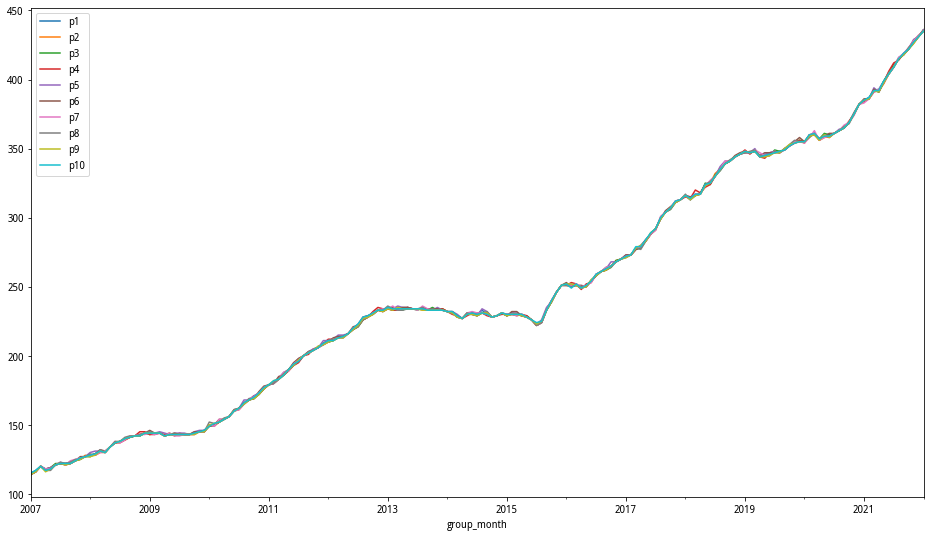

In [146]:
pf_n_stks = pd.DataFrame()
for key, value in portfolios.items():
    pf_n_stks[key] = portfolios[key].groupby('group_month')['secID'].nunique()

display(pf_n_stks)

pf_n_stks.plot()

In [147]:
portfolios['p1'].groupby('group_month')['mkt_cap'].mean()

group_month
2007-01    1.841858e+09
2007-02    1.682777e+09
2007-03    1.737450e+09
2007-04    2.521125e+09
2007-05    4.188905e+09
2007-06    9.237093e+09
2007-07    9.932140e+09
2007-08    8.396732e+09
2007-09    9.750998e+09
2007-10    8.428611e+09
               ...     
2021-04    1.032080e+10
2021-05    8.005888e+09
2021-06    1.097179e+10
2021-07    1.260609e+10
2021-08    1.849026e+10
2021-09    1.870984e+10
2021-10    1.602559e+10
2021-11    1.463806e+10
2021-12    9.991842e+09
2022-01    1.161439e+10
Freq: M, Name: mkt_cap, Length: 181, dtype: float64

p1            p2            p3            p4  \
group_month                                                           
2007-01      1.841858e+09  1.943038e+09  1.777210e+09  1.414920e+09   
2007-02      1.682777e+09  2.527809e+09  1.266863e+09  1.544814e+09   
2007-03      1.737450e+09  2.431204e+09  2.215958e+09  2.110175e+09   
2007-04      2.521125e+09  3.338960e+09  3.261171e+09  2.431854e+09   
2007-05      4.188905e+09  3.939502e+09  4.107742e+09  4.450773e+09   
2007-06      9.237093e+09  5.460309e+09  3.992653e+09  4.686009e+09   
2007-07      9.932140e+09  6.257420e+09  4.500617e+09  6.158261e+09   
2007-08      8.396732e+09  8.513733e+09  6.284102e+09  4.981579e+09   
2007-09      9.750998e+09  8.631757e+09  5.072771e+09  6.168571e+09   
2007-10      8.428611e+09  1.091845e+10  7.064819e+09  6.623532e+09   
...                   ...           ...           ...           ...   
2021-04      1.032080e+10  1.259563e+10  6.894497e+09  5.846912e+09   
2021-05      8.005888e+09  1.173213e+10  8.896026e+09  7.783550e+09   
2021-06      1.097179e+10  1.176248e+10  6.083130e+09  8.063595e+09   
2021-07      1.260609e+10  9.507344e+09  8.135374e+09  6.401204e+09   
2021-08      1.849026e+10  9.950512e+09  7.993255e+09  7.958262e+09   
2021-09      1.870984e+10  8.182419e+09  7.731165e+09  8.074105e+09   
2021-10      1.602559e+10  1.216513e+10  7.382745e+09  7.500477e+09   
2021-11      1.463806e+10  1.235815e+10  7.886236e+09  6.275675e+09   
2021-12      9.991842e+09  1.133952e+10  1.151781e+10  9.509329e+09   
2022-01      1.161439e+10  9.442511e+09  1.017635e+10  9.296245e+09   

                       p5            p6            p7            p8  \
group_month                                                           
2007-01      1.505921e+09  1.716713e+09  3.340681e+09  2.482691e+09   
2007-02      1.625754e+09  2.327875e+09  2.012284e+09  2.897000e+09   
2007-03      2.052814e+09  2.003068e+09  2.122884e+09  3.105382e+09   
2007-04      3.440276e+09  4.891935e+09  3.440453e+09  3.677309e+09   
2007-05      3.920500e+09  3.297789e+09  4.800245e+09  3.782589e+09   
2007-06      2.717176e+09  3.845387e+09  2.332206e+09  2.767248e+09   
2007-07      4.845725e+09  3.325002e+09  3.287681e+09  3.512036e+09   
2007-08      5.205058e+09  6.400708e+09  4.307121e+09  5.305199e+09   
2007-09      5.428814e+09  6.434923e+09  6.237285e+09  4.346418e+09   
2007-10      5.394069e+09  8.897506e+09  4.475824e+09  3.713254e+09   
...                   ...           ...           ...           ...   
2021-04      8.550515e+09  9.602685e+09  9.414733e+09  1.550551e+10   
2021-05      8.105374e+09  8.180020e+09  1.112839e+10  1.504571e+10   
2021-06      6.755392e+09  1.040925e+10  9.317265e+09  1.458211e+10   
2021-07      7.735417e+09  7.751402e+09  9.226945e+09  1.489279e+10   
2021-08      7.849534e+09  8.256967e+09  9.713709e+09  1.432457e+10   
2021-09      9.441716e+09  8.241004e+09  9.892104e+09  1.347281e+10   
2021-10      9.768427e+09  7.310786e+09  1.056437e+10  1.273375e+10   
2021-11      9.252716e+09  1.083504e+10  1.195608e+10  1.306100e+10   
2021-12      9.087404e+09  9.873404e+09  1.316934e+10  1.574551e+10   
2022-01      8.414955e+09  9.715671e+09  1.340281e+10  1.862179e+10   

                       p9           p10  
group_month                              
2007-01      2.896222e+09  4.039423e+09  
2007-02      4.202603e+09  5.230117e+09  
2007-03      4.562653e+09  6.218050e+09  
2007-04      4.759346e+09  6.763001e+09  
2007-05      4.503621e+09  6.345930e+09  
2007-06      3.186025e+09  3.038251e+09  
2007-07      3.754093e+09  3.768149e+09  
2007-08      4.472588e+09  5.171172e+09  
2007-09      5.440013e+09  4.939119e+09  
2007-10      4.955836e+09  4.679226e+09  
...                   ...           ...  
2021-04      2.255352e+10  6.267080e+10  
2021-05      1.987060e+10  7.208393e+10  
2021-06      2.059733e+10  7.223258e+10  
2021-07      1.955842e+10  6.621576e+10  
2021-08      2.165911e+10  6.108023e+10  

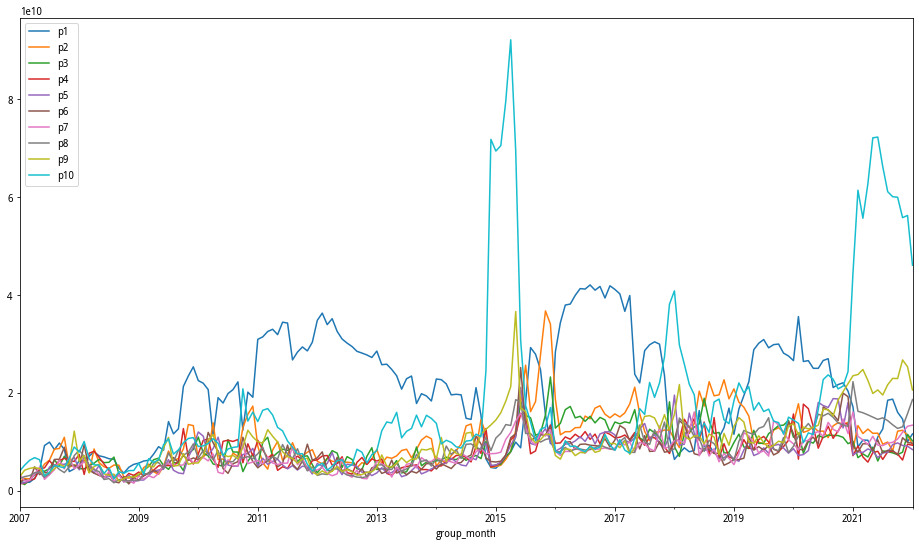

In [148]:
pf_mktcap = pd.DataFrame()
for key, value in portfolios.items():
    pf_mktcap[key] = portfolios[key].groupby('group_month')['mkt_cap'].mean()

display(pf_mktcap)

pf_mktcap.plot()

- p1 是小beta股票，在某些时候和其他组的走势很不一样
- p9, p10 是高beta股票，在2015前后有大起大落
- 其他的股票在这段时间里波动不大
- 沪深300指数的制定就是围绕p9, p10
- 指数的起落不一定是全市场的变化，有时在个股（或分组）层面存在严重的分化

In [149]:
pf_mktcap = pf_mktcap / 1e10
for i in range(10):
    print(pf_mktcap.mean()[i])

2.005138630361989
1.0536894159397059
0.857777408890237
0.79553527142843
0.7494256891973657
0.7535245359639319
0.7384869027986268
0.8403820630676221
1.0030655209264723
1.7453759292839193


## beta 单排结论

排序方法：按照上月末 beta252 分十组，考察下月各组合简单平均收益率

结论：
- 各组合收益率没有明显区别: CAPM 在中国市场也不成立
- 最小beta组合市值较大，最大beta组合市值较大
- 按beta分组的市值画图：
    - p1 是小beta股票，在某些时候和其他组的走势很不一样
    - p9, p10 是高beta股票，在2015前后有大起大落
    - 其他的股票在这段时间里波动不大
    - 沪深300指数的制定就是围绕p9, p10
    - 指数的起落不一定是全市场的变化，有时在个股（或分组）层面存在严重的分化

# Sorting on Market Capitalization

## The Size Effect

size-effect 指的是小市值股票的收益率比大市值股票更好. Fama and French (1992, 1993) 是最著名的两篇文章. 但这个现象更早就被发现了, 例如 Banz (1981), Shapiro (1986). Fama and French (2012) 说在全球市场都有类似的现象.

FF (1992) 总结了这个现象的已有文献并进一步做了检验, FF(1993)在此基础上构建了SMB因子, 并发现所谓Fama French 3 因子模型比 CAPM 表现更好.

FF 的市值是这样计算的: t年6月底的股价 * t年6月底的股本数, 也即: 

$$MktCap_{i,t}^{FF} = \frac{ShareOut_{i, June} \times Price_{i, June}}{1000}$$

作为t年至t+1年的市值分类标准. 这样做是为了避免价格的频繁变动本身带来的市值和收益率之间的相关性.

对于美国数据, ShareOut是按照1000股来衡量的, 上式再除以1000, 则$MktCap$的量纲就是"百万美元".

另外一种算法更直接:

$$MktCap_{i,t} = \frac{ShareOut_{i, t} \times Price_{i, t}}{1000}$$

对于美国市场, 两种算法得到的结果差别不大.

在做回归分析的时候, 一般还会把$MktCap$取log, 因为一般来讲会有一小部分股票有极大的市值, 而大部分股票的市值与其相比很小. 回归会收到这个影响. 而sorting不会.

我们在中国市场看看小市值股票是否比大市值股票表现更好. 简单起见, 我们用后一种MktCap算法.

## Distribution of Market Capitalization

In [150]:
ret_df['mkt_cap'] = ret_df['mkt_cap'] / 1e6

In [151]:
ret_df['size'] = np.log(ret_df['mkt_cap'])

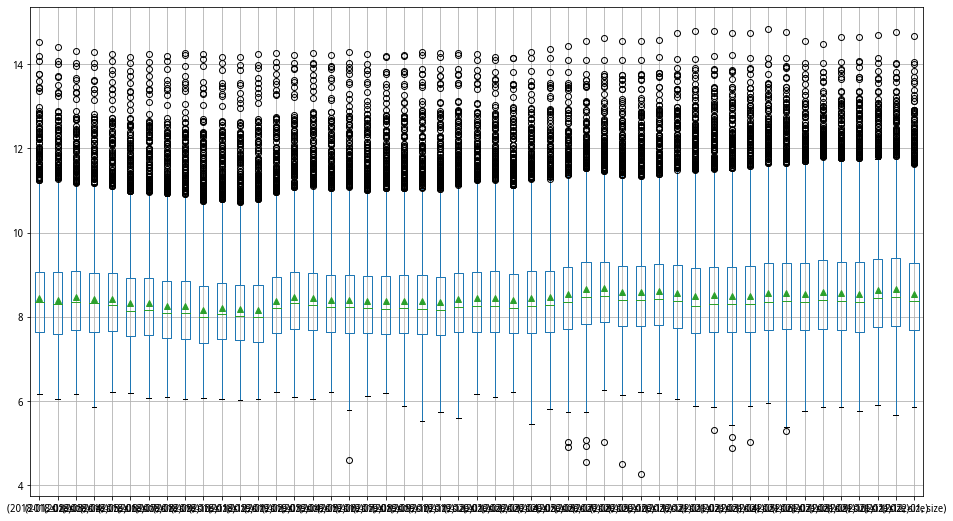

In [152]:
mktcap_group = ret_df.loc[ret_df['group_month'] >= '2018',['group_month','size']].groupby('group_month')

mktcap_group.boxplot(subplots=False, showmeans=True)

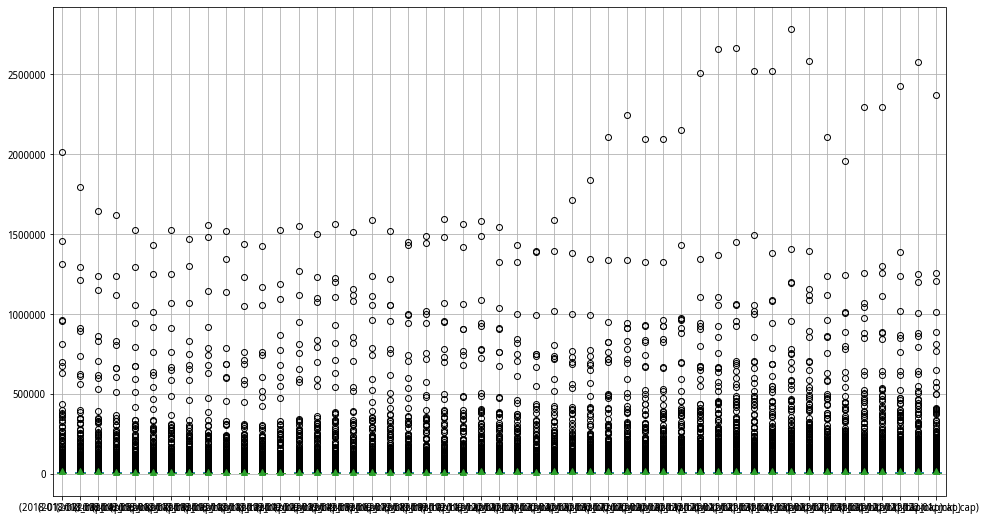

In [153]:
mktcap_group = ret_df.loc[ret_df['group_month'] >= '2018',['group_month','mkt_cap']].groupby('group_month')

mktcap_group.boxplot(subplots=False, showmeans=True)

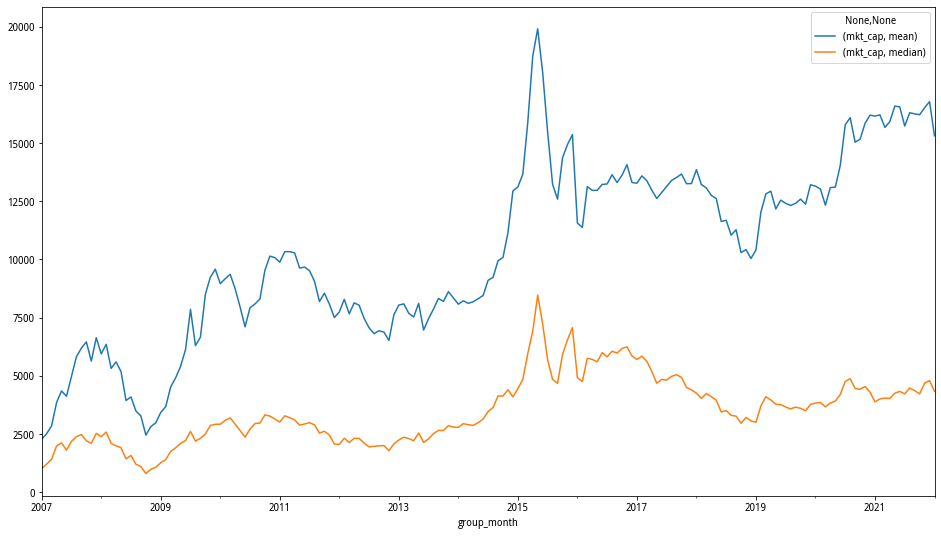

In [154]:
mktcap_group = ret_df.loc[:,['group_month','mkt_cap']].groupby('group_month')

mktcap_group.agg([np.mean, np.median]).plot()

## Average return of porfolios sorted by market cap

In [155]:
q = dict()
keys = ['q'+str(i) for i in range(1, 10)]
values = np.arange(0.1, 1.0, 0.1)
q.update(zip(keys,values))

quantile_df = pd.DataFrame()
for key, value in q.items():
    quantile_df[key] = ret_df.groupby(['group_month'])['mkt_cap'].quantile(value)

display(quantile_df)

ret_df_q = pd.merge(ret_df, quantile_df, on='group_month')

display(ret_df_q)

portfolios = dict()

portfolios['p1'] = ret_df_q.loc[ret_df_q['mkt_cap'] <= ret_df_q['q1'],['secID','group_month','mkt_cap','Beta252','ret_month','exret']].copy()
for i in range(2,10):
    idx = (ret_df_q[f'q{i-1}'] <= ret_df_q['mkt_cap']) & (ret_df_q['mkt_cap'] <= ret_df_q[f'q{i}'])
    portfolios[f'p{i}'] = ret_df_q.loc[idx,['secID','group_month','mkt_cap','Beta252','ret_month','exret']].copy()
portfolios['p10'] = ret_df_q.loc[ret_df_q['mkt_cap'] >= ret_df_q['q9'],['secID','group_month','mkt_cap','Beta252','ret_month','exret']].copy()

for k in portfolios.keys():
    print(portfolios[k].groupby(['ret_month'])['exret'].mean().mean())

q1           q2           q3           q4           q5  \
group_month                                                                    
2007-01       363.136000   480.899993   620.579186   778.271272  1009.712040   
2007-02       440.805422   595.545624   758.492864   956.487864  1200.059661   
2007-03       536.037956   720.901965   906.773589  1140.678258  1415.057717   
2007-04       712.397967   971.802666  1259.191694  1559.834393  1983.185236   
2007-05       743.697368  1031.270105  1368.321956  1656.882500  2113.283484   
2007-06       584.955291   794.620158  1069.309176  1374.969140  1801.920298   
2007-07       751.028063  1029.940878  1375.391250  1718.640000  2179.698505   
2007-08       821.381936  1131.576773  1463.914269  1898.983183  2377.905578   
2007-09       816.978571  1136.686436  1485.175110  1959.318136  2473.718728   
2007-10       713.653572   988.297321  1287.667261  1735.791214  2205.512326   
...                  ...          ...          ...          ...          ...   
2021-04      1147.552470  1788.673853  2383.686640  3158.549640  4022.183106   
2021-05      1231.583742  1875.201322  2535.586945  3310.287517  4252.572594   
2021-06      1212.913440  1887.528310  2564.452675  3304.451619  4327.233550   
2021-07      1197.570304  1838.000000  2502.176976  3261.093723  4221.315225   
2021-08      1244.720676  1947.124998  2615.806508  3416.500377  4472.569967   
2021-09      1186.434930  1882.549716  2525.329671  3326.345724  4362.087110   
2021-10      1128.064242  1787.120650  2459.144471  3199.059348  4219.724178   
2021-11      1308.867188  1979.730287  2729.025965  3550.842651  4680.158855   
2021-12      1316.880484  2046.113016  2783.934409  3650.948086  4789.301852   
2022-01      1206.231157  1875.682509  2528.048469  3303.239176  4330.559446   

                      q6           q7            q8            q9  
group_month                                                        
2007-01      1304.849054  1697.231735   2507.171931   4344.497960  
2007-02      1535.447840  1975.074794   2859.650826   4853.532162  
2007-03      1798.094208  2332.942812   3268.566989   5346.252277  
2007-04      2494.016879  3122.942373   4616.164880   7284.993425  
2007-05      2647.349340  3531.551640   5171.464772   8356.197994  
2007-06      2258.638080  3065.348329   4750.440762   8228.836507  
2007-07      2770.854735  3745.274955   5705.479154   9720.226264  
2007-08      3032.868807  4191.388059   6390.407237  11239.060700  
2007-09      3221.473206  4354.705013   6699.498851  12463.583963  
2007-10      2925.338189  4000.675394   6142.609475  11851.145793  
...                  ...          ...           ...           ...  
2021-04      5466.392319  7745.433078  13086.103320  26885.040919  
2021-05      5727.609965  8183.506076  13850.073254  28088.965732  
2021-06      5807.659723  8450.329898  13904.059615  28425.881994  
2021-07      5802.553572  8335.414410  14063.143368  27984.345564  
2021-08      6098.817994  8822.871074  15130.206458  29504.609559  
2021-09      5926.080614  8840.195820  14753.858198  29328.001103  
2021-10      5713.163784  8468.326208  14371.758720  28943.588160  
2021-11      6366.924325  9166.139607  15481.377986  29565.561557  
2021-12      6480.795955  9439.092184  15468.894014  30267.933014  
2022-01      5841.778341  8399.927808  13667.236157  26981.683935  

[181 rows x 9 columns]

secID ret_month     exret group_month        mkt_cap  Beta252  \
0       000001.XSHE   2007-07  0.313877     2007-06   42661.167898   0.4614   
1       000002.XSHE   2007-07  0.477505     2007-06   93332.479948   1.1541   
2       000006.XSHE   2007-07  0.282520     2007-06    5443.212086   1.0607   
3       000012.XSHE   2007-07  0.253637     2007-06    5096.113844   1.2944   
4       000014.XSHE   2007-07  0.547459     2007-06    1470.027591   0.9626   
5       000016.XSHE   2007-07  0.160653     2007-06    2213.931060   1.1464   
6       000018.XSHE   2007-07  0.276978     2007-06     226.419277   1.1392   
7       000021.XSHE   2007-07  0.136982     2007-06    5315.984592   1.1945   
8       000022.XSHE   2007-07  0.095368     2007-06    2484.607570   0.7355   
9       000023.XSHE   2007-07  0.348274     2007-06     551.772130   1.3330   
...             ...       ...       ...         ...            ...      ...   
454428  601899.XSHG   2010-09  0.116373     2010-08   41112.285370   0.9049   
454429  601918.XSHG   2010-09 -0.022752     2010-08   12709.525306   1.3989   
454430  601919.XSHG   2010-09 -0.022287     2010-08   21434.016390   1.2138   
454431  601939.XSHG   2010-09 -0.019112     2010-08   42120.000000   0.6709   
454432  601958.XSHG   2010-09  0.203846     2010-08   11873.215224   1.4165   
454433  601988.XSHG   2010-09  0.000871     2010-08  592136.972764   0.5898   
454434  601989.XSHG   2010-09 -0.035674     2010-08   17855.250000   0.5208   
454435  601991.XSHG   2010-09 -0.010821     2010-08   58404.084000   0.7183   
454436  601998.XSHG   2010-09 -0.097995     2010-08  148731.686086   1.1555   
454437  601999.XSHG   2010-09 -0.000508     2010-08    1813.000000   0.9296   

             size          q1           q2           q3           q4  \
0       10.661044  584.955291   794.620158  1069.309176  1374.969140   
1       11.443923  584.955291   794.620158  1069.309176  1374.969140   
2        8.602125  584.955291   794.620158  1069.309176  1374.969140   
3        8.536234  584.955291   794.620158  1069.309176  1374.969140   
4        7.293036  584.955291   794.620158  1069.309176  1374.969140   
5        7.702525  584.955291   794.620158  1069.309176  1374.969140   
6        5.422388  584.955291   794.620158  1069.309176  1374.969140   
7        8.578474  584.955291   794.620158  1069.309176  1374.969140   
8        7.817870  584.955291   794.620158  1069.309176  1374.969140   
9        6.313135  584.955291   794.620158  1069.309176  1374.969140   
...           ...         ...          ...          ...          ...   
454428  10.624062  860.322000  1313.038953  1855.474313  2325.109053   
454429   9.450107  860.322000  1313.038953  1855.474313  2325.109053   
454430   9.972734  860.322000  1313.038953  1855.474313  2325.109053   
454431  10.648278  860.322000  1313.038953  1855.474313  2325.109053   
454432   9.382040  860.322000  1313.038953  1855.474313  2325.109053   
454433  13.291493  860.322000  1313.038953  1855.474313  2325.109053   
454434   9.790053  860.322000  1313.038953  1855.474313  2325.109053   
454435  10.975141  860.322000  1313.038953  1855.474313  2325.109053   
454436  11.909899  860.322000  1313.038953  1855.474313  2325.109053   
454437   7.502738  860.322000  1313.038953  1855.474313  2325.109053   

                 q5           q6           q7           q8            q9  
0       1801.920298  2258.638080  3065.348329  4750.440762   8228.836507  
1       1801.920298  2258.638080  3065.348329  4750.440762   8228.836507  
2       1801.920298  2258.638080  3065.348329  4750.440762   8228.836507  
3       1801.920298  2258.638080  3065.348329  4750.440762   8228.836507  
4       1801.920298  2258.638080  3065.348329  4750.440762   8228.836507  
5       1801.920298  2258.638080  3065.348329  4750.440762   8228.836507  
6       1801.920298  2258.638080  3065.348329  4750.440762   8228.836507  
7       1801.920298  2258.638080  3065.348329  4750.440762   8228.836507  
8       1801.92

0.034280643063306526
0.019639475232622203
0.017819286168396377
0.014974540223355617
0.01206761952347478
0.009793931840495712
0.009391260549163689
0.00843288968653358
0.00689659257312407
0.005428309257176666


### More robust by adjusting Newey-West errors

In [156]:
portfolios_crs_mean = dict()
for k in portfolios.keys():
    portfolios_crs_mean[k] = portfolios[k].groupby(['ret_month'])['exret'].mean()

In [157]:
portfolios_crs_mean['p1']

ret_month
2007-02    0.213746
2007-03    0.227285
2007-04    0.274456
2007-05    0.043539
2007-06   -0.185196
2007-07    0.290971
2007-08    0.098388
2007-09   -0.008755
2007-10   -0.113157
2007-11   -0.027550
             ...   
2021-05    0.073848
2021-06    0.026453
2021-07   -0.021071
2021-08    0.069888
2021-09   -0.058513
2021-10   -0.033508
2021-11    0.206178
2021-12   -0.005183
2022-01   -0.081537
2022-02    0.036480
Freq: M, Name: exret, Length: 181, dtype: float64

In [158]:
mean_values = {}
t_values = {}
for k in portfolios_crs_mean.keys():
    y = portfolios_crs_mean[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
# Portfolio 10-1
y = portfolios_crs_mean['p10'] - portfolios_crs_mean['p1']
const = np.full(shape=len(y), fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
mean_values['p10-p1'] = reg.params[0]
t_values['p10-p1'] = reg.tvalues[0]

In [159]:
mean_values

{'p1': 0.034280643063306554,
 'p2': 0.019639475232622203,
 'p3': 0.01781928616839638,
 'p4': 0.014974540223355606,
 'p5': 0.01206761952347478,
 'p6': 0.009793931840495701,
 'p7': 0.009391260549163684,
 'p8': 0.008432889686533579,
 'p9': 0.006896592573124071,
 'p10': 0.0054283092571766715,
 'p10-p1': -0.02885233380612988}

In [160]:
t_values

{'p1': 3.034337741778285,
 'p2': 2.2176214358361186,
 'p3': 2.10104466638333,
 'p4': 1.7916959016705458,
 'p5': 1.4688270634745713,
 'p6': 1.2034797550841698,
 'p7': 1.1480213654606852,
 'p8': 1.0354411721600274,
 'p9': 0.8825377674240781,
 'p10': 0.6933010097677015,
 'p10-p1': -3.322234397096092}

In [161]:
pd.DataFrame([mean_values.values(),t_values.values()],index=['mean','t-value'],
             columns=mean_values.keys())

p1        p2        p3        p4        p5        p6        p7  \
mean     0.034281  0.019639  0.017819  0.014975  0.012068  0.009794  0.009391   
t-value  3.034338  2.217621  2.101045  1.791696  1.468827  1.203480  1.148021   

               p8        p9       p10    p10-p1  
mean     0.008433  0.006897  0.005428 -0.028852  
t-value  1.035441  0.882538  0.693301 -3.322234

## Portfolio characteristics other than return

In [162]:
# average mktcap in each portfolio
for key in portfolios.keys():
    print(portfolios[key].groupby('group_month')['mkt_cap'].mean().mean())  

801.6883736923252
1389.4442855864659
1918.5432452286711
2468.4726827275886
3106.3787242580947
3938.2624260223374
5158.054385430857
7255.20818716762
11991.170957342927
65170.734237345976


In [163]:
portfolios['p1'].groupby('group_month')['secID'].nunique()

group_month
2007-01    119
2007-02    121
2007-03    123
2007-04    120
2007-05    121
2007-06    123
2007-07    124
2007-08    125
2007-09    126
2007-10    127
          ... 
2021-04    405
2021-05    412
2021-06    419
2021-07    424
2021-08    428
2021-09    431
2021-10    435
2021-11    438
2021-12    443
2022-01    445
Freq: M, Name: secID, Length: 181, dtype: int64

In [164]:
pf_n_stks = pd.DataFrame()
for key, value in portfolios.items():
    pf_n_stks[key] = portfolios[key].groupby('group_month')['secID'].nunique()

In [165]:
pf_n_stks

p1   p2   p3   p4   p5   p6   p7   p8   p9  p10
group_month                                                  
2007-01      119  118  118  118  119  119  118  118  118  119
2007-02      121  120  121  120  121  121  120  121  120  121
2007-03      123  123  123  123  123  123  123  123  123  123
2007-04      120  120  120  120  120  120  120  120  120  120
2007-05      121  120  121  120  121  121  120  121  120  121
2007-06      123  122  122  123  122  122  123  122  122  123
2007-07      124  124  124  123  124  124  124  124  124  124
2007-08      125  124  125  124  125  125  124  125  124  125
2007-09      126  126  126  126  126  126  126  126  126  126
2007-10      127  127  127  126  127  127  126  127  127  127
...          ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
2021-04      405  404  404  405  404  404  405  404  404  405
2021-05      412  412  411  412  412  412  412  411  412  412
2021-06      419  418  419  418  419  419  418  419  418  419
2021-07      424  424  424  424  424  424  424  424  424  424
2021-08      428  427  427  427  427  427  427  427  427  428
2021-09      431  431  431  431  431  431  431  431  431  431
2021-10      435  435  435  435  435  435  435  435  435  435
2021-11      438  437  437  438  437  437  438  437  437  438
2021-12      443  442  442  442  442  442  442  442  442  443
2022-01      445  445  445  445  445  445  445  445  445  445

[181 rows x 10 columns]

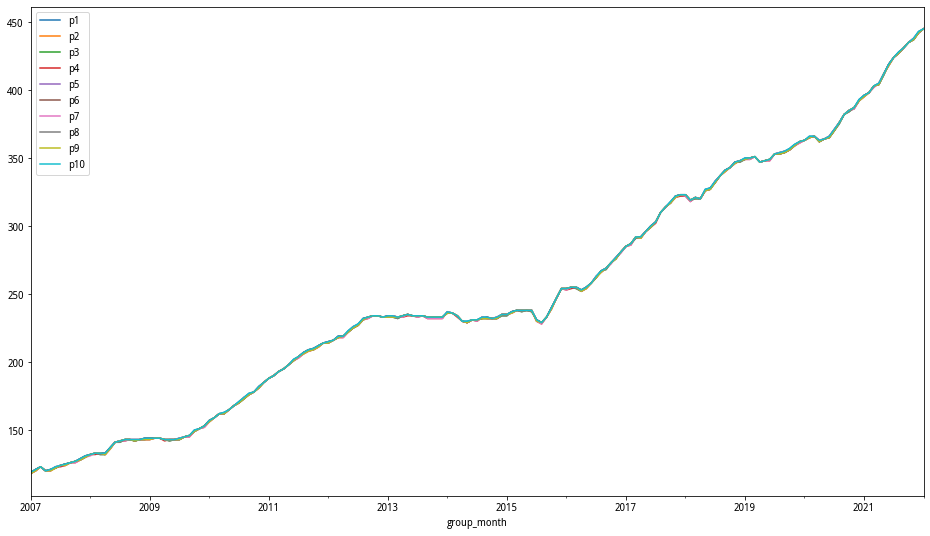

In [166]:
pf_n_stks.plot()

In [167]:
portfolios['p1']

secID group_month     mkt_cap  Beta252 ret_month     exret
6       000018.XSHE     2007-06  226.419277   1.1392   2007-07  0.276978
9       000023.XSHE     2007-06  551.772130   1.3330   2007-07  0.348274
23      000045.XSHE     2007-06  278.690268   1.2613   2007-07  0.331251
25      000049.XSHE     2007-06  558.933282   1.0612   2007-07  0.471941
55      000411.XSHE     2007-06  320.453112   1.1230   2007-07  0.430651
89      000526.XSHE     2007-06  365.560874   1.1659   2007-07  0.320882
134     000591.XSHE     2007-06  572.867451   1.1541   2007-07  0.148080
135     000593.XSHE     2007-06  493.523391   1.3634   2007-07  0.313966
158     000626.XSHE     2007-06  411.706102   1.1284   2007-07  0.225835
166     000639.XSHE     2007-06  583.779030   0.8081   2007-07 -0.266856
...             ...         ...         ...      ...       ...       ...
453660  300106.XSHE     2010-08  681.120000      NaN   2010-09 -0.246316
453661  300107.XSHE     2010-08  817.824800      NaN   2010-09 -0.034863
453662  300108.XSHE     2010-08  313.976000      NaN   2010-09 -0.111106
453663  300109.XSHE     2010-08  488.880000      NaN   2010-09 -0.055296
453666  300112.XSHE     2010-08  373.680000      NaN   2010-09 -0.064943
453668  300114.XSHE     2010-08  635.200000      NaN   2010-09 -0.168377
454221  600745.XSHG     2010-08  760.530730   1.1339   2010-09  0.169035
454227  600753.XSHG     2010-08  813.865067   1.0364   2010-09  0.068847
454238  600766.XSHG     2010-08  606.346178   1.0449   2010-09  0.007923
454240  600768.XSHG     2010-08  858.314674   0.9935   2010-09  0.013298

[45522 rows x 6 columns]

In [168]:
pf_beta = pd.DataFrame()
for key, value in portfolios.items():
    pf_beta[key] = portfolios[key].groupby('group_month')['Beta252'].mean()

In [169]:
for col in pf_beta.columns:
    print(pf_beta.loc[:,col].mean())

0.9513623071630467
0.941547759467301
0.9337894525876917
0.9362475005947629
0.937326346231242
0.9484911552983158
0.9534275837882672
0.9638516443699919
0.9781162796946969
0.9973117975408449


## Market Capitalization 单排结论

排序方法：上月末市值按大小分成10组，考察下月收益率

- 收益率随市值增大减小
- 各组之间beta无显著区别

### Different time periods

In [170]:
ret_df_q_ = ret_df_q[(ret_df_q['group_month']>='2016') & (ret_df_q['group_month']<='2020')].copy()

In [171]:
portfolios = dict()

portfolios['p1'] = ret_df_q_.loc[ret_df_q_['mkt_cap'] <= ret_df_q_['q1'],['secID','group_month','mkt_cap','Beta252','ret_month','exret']].copy()
for i in range(2,10):
    idx = (ret_df_q_[f'q{i-1}'] <= ret_df_q_['mkt_cap']) & (ret_df_q_['mkt_cap'] <= ret_df_q_[f'q{i}'])
    portfolios[f'p{i}'] = ret_df_q_.loc[idx,['secID','group_month','mkt_cap','Beta252','ret_month','exret']].copy()
portfolios['p10'] = ret_df_q_.loc[ret_df_q_['mkt_cap'] >= ret_df_q_['q9'],['secID','group_month','mkt_cap','Beta252','ret_month','exret']].copy()
portfolios_crs_mean = dict()
for k in portfolios.keys():
    portfolios_crs_mean[k] = portfolios[k].groupby(['ret_month'])['exret'].mean()
mean_values = {}
t_values = {}
for k in portfolios_crs_mean.keys():
    y = portfolios_crs_mean[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
# Portfolio 10-1
y = portfolios_crs_mean['p10'] - portfolios_crs_mean['p1']
const = np.full(shape=len(y), fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
mean_values['p10-p1'] = reg.params[0]
t_values['p10-p1'] = reg.tvalues[0]
pd.DataFrame([mean_values.values(),t_values.values()],index=['mean','t-value'],
             columns=mean_values.keys())

p1        p2        p3        p4        p5        p6        p7  \
mean     0.026530 -0.000431 -0.000663 -0.002277 -0.003996 -0.004535 -0.005125   
t-value  1.827007 -0.039014 -0.065590 -0.230062 -0.410834 -0.473493 -0.589307   

               p8        p9       p10    p10-p1  
mean    -0.004076 -0.000987  0.004180 -0.022350  
t-value -0.496327 -0.130577  0.651484 -1.922722

In [172]:
del ret_df_q_
gc.collect()

182

In [173]:
stk_info[stk_info['secShortName']=='贵州茅台']

secID  ticker secShortName cnSpell exchangeCD assetClass  \
9403  600519.XSHG  600519         贵州茅台    GZMT       XSHG          E   

     listStatusCD    listDate transCurrCD          ISIN  partyID delistDate  
9403            L  2001-08-27         CNY  CNE0000018R8   1033.0        NaN

In [174]:
portfolios['p10'][portfolios['p10']['secID']=='600519.XSHG']

secID group_month       mkt_cap  Beta252 ret_month     exret
195730  600519.XSHG     2016-01  2.520561e+05   0.6056   2016-02  0.068566
198265  600519.XSHG     2016-02  2.699695e+05   0.5933   2016-03  0.149955
200810  600519.XSHG     2016-03  3.110848e+05   0.5581   2016-04  0.011995
203332  600519.XSHG     2016-04  3.155569e+05   0.5374   2016-05  0.050397
205866  600519.XSHG     2016-05  3.322266e+05   0.5744   2016-06  0.101331
208439  600519.XSHG     2016-06  3.667093e+05   0.6273   2016-07  0.093479
211054  600519.XSHG     2016-07  3.933783e+05   0.6959   2016-08 -0.011790
213706  600519.XSHG     2016-08  3.896600e+05   0.6746   2016-09 -0.041916
216384  600519.XSHG     2016-09  3.742339e+05   0.7520   2016-10  0.064930
219089  600519.XSHG     2016-10  3.994081e+05   0.7712   2016-11  0.001121
...             ...         ...           ...      ...       ...       ...
314466  600519.XSHG     2019-04  1.223537e+06   1.0014   2019-05 -0.088665
317940  600519.XSHG     2019-05  1.118016e+06   1.0802   2019-06  0.119586
321422  600519.XSHG     2019-06  1.236099e+06   1.1061   2019-07 -0.013770
324912  600519.XSHG     2019-07  1.221778e+06   1.1227   2019-08  0.171954
328440  600519.XSHG     2019-08  1.434578e+06   1.1266   2019-09  0.004744
331979  600519.XSHG     2019-09  1.444627e+06   1.1315   2019-10  0.023792
335529  600519.XSHG     2019-10  1.482326e+06   1.1127   2019-11 -0.045719
339102  600519.XSHG     2019-11  1.418247e+06   1.0537   2019-12  0.045306
342702  600519.XSHG     2019-12  1.486082e+06   1.0307   2020-01 -0.112462
346322  600519.XSHG     2020-01  1.322525e+06   0.9036   2020-02  0.001811

[49 rows x 6 columns]

# Double Sorting on Beta and Market Capitalization

我们做 independent sort, mktcap 分2组，beta 分3组。mktcap的分位点是0.5，beta的分位点是0.3，0.7

In [175]:
q_mktcap = dict()
keys = ['q_mktcap_1']
values = [0.5]
q_mktcap.update(zip(keys,values))

q_beta = dict()
keys = ['q_beta_1','q_beta_2']
values = [0.3, 0.7]
q_beta.update(zip(keys,values))

q_mktcap_df = pd.DataFrame()
for key, value in q_mktcap.items():
    q_mktcap_df[key] = ret_df.groupby(['group_month'])['mkt_cap'].quantile(value)

q_beta_df = pd.DataFrame()
for key, value in q_beta.items():
    q_beta_df[key] = ret_df.groupby(['group_month'])['Beta252'].quantile(value)

In [176]:
q_mktcap_df

q_mktcap_1
group_month             
2007-01      1009.712040
2007-02      1200.059661
2007-03      1415.057717
2007-04      1983.185236
2007-05      2113.283484
2007-06      1801.920298
2007-07      2179.698505
2007-08      2377.905578
2007-09      2473.718728
2007-10      2205.512326
...                  ...
2021-04      4022.183106
2021-05      4252.572594
2021-06      4327.233550
2021-07      4221.315225
2021-08      4472.569967
2021-09      4362.087110
2021-10      4219.724178
2021-11      4680.158855
2021-12      4789.301852
2022-01      4330.559446

[181 rows x 1 columns]

In [177]:
q_beta_df

q_beta_1  q_beta_2
group_month                    
2007-01       0.84375   1.04154
2007-02       0.86143   1.01157
2007-03       0.84380   1.00440
2007-04       0.88230   1.04780
2007-05       0.92456   1.09670
2007-06       1.03820   1.23300
2007-07       1.03030   1.22750
2007-08       0.97580   1.16502
2007-09       0.97647   1.16160
2007-10       0.97690   1.16970
...               ...       ...
2021-04       0.29809   0.60110
2021-05       0.25549   0.56394
2021-06       0.25790   0.57330
2021-07       0.26200   0.55812
2021-08       0.31790   0.61590
2021-09       0.31349   0.59841
2021-10       0.33148   0.62840
2021-11       0.33722   0.63366
2021-12       0.32692   0.63739
2022-01       0.40535   0.73900

[181 rows x 2 columns]

In [178]:
ret_df_q = pd.merge(ret_df, q_mktcap_df, on='group_month')
ret_df_q = pd.merge(ret_df_q, q_beta_df, on='group_month')

In [179]:
ret_df_q

secID ret_month     exret group_month        mkt_cap  Beta252  \
0       000001.XSHE   2007-07  0.313877     2007-06   42661.167898   0.4614   
1       000002.XSHE   2007-07  0.477505     2007-06   93332.479948   1.1541   
2       000006.XSHE   2007-07  0.282520     2007-06    5443.212086   1.0607   
3       000012.XSHE   2007-07  0.253637     2007-06    5096.113844   1.2944   
4       000014.XSHE   2007-07  0.547459     2007-06    1470.027591   0.9626   
5       000016.XSHE   2007-07  0.160653     2007-06    2213.931060   1.1464   
6       000018.XSHE   2007-07  0.276978     2007-06     226.419277   1.1392   
7       000021.XSHE   2007-07  0.136982     2007-06    5315.984592   1.1945   
8       000022.XSHE   2007-07  0.095368     2007-06    2484.607570   0.7355   
9       000023.XSHE   2007-07  0.348274     2007-06     551.772130   1.3330   
...             ...       ...       ...         ...            ...      ...   
454428  601899.XSHG   2010-09  0.116373     2010-08   41112.285370   0.9049   
454429  601918.XSHG   2010-09 -0.022752     2010-08   12709.525306   1.3989   
454430  601919.XSHG   2010-09 -0.022287     2010-08   21434.016390   1.2138   
454431  601939.XSHG   2010-09 -0.019112     2010-08   42120.000000   0.6709   
454432  601958.XSHG   2010-09  0.203846     2010-08   11873.215224   1.4165   
454433  601988.XSHG   2010-09  0.000871     2010-08  592136.972764   0.5898   
454434  601989.XSHG   2010-09 -0.035674     2010-08   17855.250000   0.5208   
454435  601991.XSHG   2010-09 -0.010821     2010-08   58404.084000   0.7183   
454436  601998.XSHG   2010-09 -0.097995     2010-08  148731.686086   1.1555   
454437  601999.XSHG   2010-09 -0.000508     2010-08    1813.000000   0.9296   

             size   q_mktcap_1  q_beta_1  q_beta_2  
0       10.661044  1801.920298   1.03820   1.23300  
1       11.443923  1801.920298   1.03820   1.23300  
2        8.602125  1801.920298   1.03820   1.23300  
3        8.536234  1801.920298   1.03820   1.23300  
4        7.293036  1801.920298   1.03820   1.23300  
5        7.702525  1801.920298   1.03820   1.23300  
6        5.422388  1801.920298   1.03820   1.23300  
7        8.578474  1801.920298   1.03820   1.23300  
8        7.817870  1801.920298   1.03820   1.23300  
9        6.313135  1801.920298   1.03820   1.23300  
...           ...          ...       ...       ...  
454428  10.624062  2945.158595   0.92976   1.12146  
454429   9.450107  2945.158595   0.92976   1.12146  
454430   9.972734  2945.158595   0.92976   1.12146  
454431  10.648278  2945.158595   0.92976   1.12146  
454432   9.382040  2945.158595   0.92976   1.12146  
454433  13.291493  2945.158595   0.92976   1.12146  
454434   9.790053  2945.158595   0.92976   1.12146  
454435  10.975141  2945.158595   0.92976   1.12146  
454436  11.909899  2945.158595   0.92976   1.12146  
454437   7.502738  2945.158595   0.92976   1.12146  

[454438 rows x 10 columns]

In [180]:
portfolios_mktcap = dict()
portfolios_mktcap['mktcap1'] = ret_df_q.loc[ret_df_q['mkt_cap'] <= ret_df_q['q_mktcap_1'],
                                           ['secID','group_month','ret_month','exret','mkt_cap']]
portfolios_mktcap['mktcap2'] = ret_df_q.loc[ret_df_q['mkt_cap'] >= ret_df_q['q_mktcap_1'],
                                           ['secID','group_month','ret_month','exret','mkt_cap']]

portfolios_beta = dict()
portfolios_beta['beta1'] = ret_df_q.loc[ret_df_q['Beta252'] <= ret_df_q['q_beta_1'],
                                           ['secID','group_month','ret_month','exret','Beta252']]
portfolios_beta['beta2'] = ret_df_q.loc[(ret_df_q['Beta252'] >= ret_df_q['q_beta_1']) & \
                                           (ret_df_q['Beta252'] <= ret_df_q['q_beta_2']),
                                           ['secID','group_month','ret_month','exret','Beta252']]
portfolios_beta['beta3'] = ret_df_q.loc[ret_df_q['Beta252'] >= ret_df_q['q_beta_2'],
                                           ['secID','group_month','ret_month','exret','Beta252']]

In [181]:
portfolios_mktcap

{'mktcap1':               secID group_month ret_month     exret      mkt_cap
 4       000014.XSHE     2007-06   2007-07  0.547459  1470.027591
 6       000018.XSHE     2007-06   2007-07  0.276978   226.419277
 9       000023.XSHE     2007-06   2007-07  0.348274   551.772130
 12      000028.XSHE     2007-06   2007-07  0.618998  1156.701744
 15      000032.XSHE     2007-06   2007-07  0.275006   848.438067
 16      000033.XSHE     2007-06   2007-07  0.126208  1130.280807
 18      000037.XSHE     2007-06   2007-07  0.228398  1067.558164
 23      000045.XSHE     2007-06   2007-07  0.331251   278.690268
 25      000049.XSHE     2007-06   2007-07  0.471941   558.933282
 26      000050.XSHE     2007-06   2007-07  0.197368  1297.892090
 ...             ...         ...       ...       ...          ...
 454370  601000.XSHG     2010-08   2010-09 -0.041671  1254.400000
 454376  601007.XSHG     2010-08   2010-09  0.015708  2520.000000
 454386  601139.XSHG     2010-08   2010-09 -0.008051  1544.400000

In [182]:
portfolios_beta

{'beta1':               secID group_month ret_month     exret  Beta252
 0       000001.XSHE     2007-06   2007-07  0.313877   0.4614
 4       000014.XSHE     2007-06   2007-07  0.547459   0.9626
 8       000022.XSHE     2007-06   2007-07  0.095368   0.7355
 11      000027.XSHE     2007-06   2007-07  0.123433   0.9700
 16      000033.XSHE     2007-06   2007-07  0.126208   0.9587
 24      000046.XSHE     2007-06   2007-07  0.519563   1.0017
 28      000056.XSHE     2007-06   2007-07  0.156088   0.5465
 32      000063.XSHE     2007-06   2007-07  0.047591   0.7719
 33      000065.XSHE     2007-06   2007-07  0.315912   1.0286
 45      000157.XSHE     2007-06   2007-07  0.040234   0.9718
 ...             ...         ...       ...       ...      ...
 454410  601668.XSHG     2010-08   2010-09 -0.038328   0.6872
 454417  601766.XSHG     2010-08   2010-09  0.111117   0.6263
 454422  601857.XSHG     2010-08   2010-09  0.003951   0.6738
 454426  601888.XSHG     2010-08   2010-09 -0.015775   0.8846

In [183]:
portfolios = dict()
for beta_group in portfolios_beta.keys():
    for mktcap_group in portfolios_mktcap.keys():
        portfolios[f'{beta_group}_{mktcap_group}'] = pd.merge(portfolios_mktcap[mktcap_group],
                                                              portfolios_beta[beta_group][['secID','ret_month','Beta252']],
                                                              on=['secID','ret_month'])

In [184]:
portfolios

{'beta1_mktcap1':              secID group_month ret_month     exret      mkt_cap  Beta252
 0      000014.XSHE     2007-06   2007-07  0.547459  1470.027591   0.9626
 1      000033.XSHE     2007-06   2007-07  0.126208  1130.280807   0.9587
 2      000056.XSHE     2007-06   2007-07  0.156088   855.168335   0.5465
 3      000065.XSHE     2007-06   2007-07  0.315912   851.976823   1.0286
 4      000404.XSHE     2007-06   2007-07  0.464207   886.818738   1.0282
 5      000421.XSHE     2007-06   2007-07  0.146840  1337.255945   0.9405
 6      000514.XSHE     2007-06   2007-07  0.168631  1463.026213   0.9382
 7      000519.XSHE     2007-06   2007-07  0.177873   748.285998   1.0303
 8      000524.XSHE     2007-06   2007-07  0.154258   862.354825   0.8963
 9      000540.XSHE     2007-06   2007-07  0.171297  1400.215461   0.4441
 ...            ...         ...       ...       ...          ...      ...
 66216  600969.XSHG     2010-08   2010-09  0.085032  1219.680000   0.9204
 66217  600976.XSHG  

In [185]:
mean_portfolios_ret = dict()
for pf in portfolios.keys():
    mean_portfolios_ret[pf] = portfolios[pf].groupby('ret_month')['exret'].mean()
    print(mean_portfolios_ret[pf].shape) # print 看一下会不会存在某个月份上beta和mktcap分组没有任何交叉

(181,)
(181,)
(181,)
(181,)
(181,)
(181,)


In [186]:
mean_portfolios_ret

{'beta1_mktcap1': ret_month
 2007-02    0.203591
 2007-03    0.202568
 2007-04    0.298113
 2007-05    0.067949
 2007-06   -0.178821
 2007-07    0.219605
 2007-08    0.062544
 2007-09    0.006220
 2007-10   -0.099815
 2007-11   -0.050263
              ...   
 2021-05    0.061292
 2021-06    0.012272
 2021-07   -0.018610
 2021-08    0.064568
 2021-09   -0.003583
 2021-10   -0.029269
 2021-11    0.112226
 2021-12    0.044746
 2022-01   -0.073001
 2022-02    0.053164
 Freq: M, Name: exret, Length: 181, dtype: float64, 'beta1_mktcap2': ret_month
 2007-02    0.116165
 2007-03    0.123316
 2007-04    0.287349
 2007-05    0.090670
 2007-06   -0.096137
 2007-07    0.143064
 2007-08    0.107968
 2007-09    0.022732
 2007-10   -0.043639
 2007-11   -0.110367
              ...   
 2021-05    0.039865
 2021-06   -0.002530
 2021-07   -0.025294
 2021-08    0.081045
 2021-09    0.019750
 2021-10   -0.045710
 2021-11    0.046247
 2021-12    0.032580
 2022-01   -0.088771
 2022-02    0.045225
 Freq: M, N

In [187]:
# Fast merge by stacking
mean_portfolios_ret_df = pd.DataFrame(np.vstack([pf for pf in mean_portfolios_ret.values()])).T
mean_portfolios_ret_df.columns = mean_portfolios_ret.keys()
mean_portfolios_ret_df.index = mean_portfolios_ret['beta1_mktcap1'].index

In [188]:
mean_portfolios_ret_df

beta1_mktcap1  beta1_mktcap2  beta2_mktcap1  beta2_mktcap2  \
ret_month                                                               
2007-02         0.203591       0.116165       0.231690       0.163670   
2007-03         0.202568       0.123316       0.205977       0.132942   
2007-04         0.298113       0.287349       0.338626       0.350411   
2007-05         0.067949       0.090670       0.071019       0.106983   
2007-06        -0.178821      -0.096137      -0.220756      -0.138289   
2007-07         0.219605       0.143064       0.302333       0.227627   
2007-08         0.062544       0.107968       0.120123       0.157550   
2007-09         0.006220       0.022732       0.025159       0.072773   
2007-10        -0.099815      -0.043639      -0.125332      -0.094356   
2007-11        -0.050263      -0.110367      -0.022939      -0.120881   
...                  ...            ...            ...            ...   
2021-05         0.061292       0.039865       0.072183       0.038984   
2021-06         0.012272      -0.002530       0.036778       0.013820   
2021-07        -0.018610      -0.025294       0.008534      -0.017363   
2021-08         0.064568       0.081045       0.070232       0.071313   
2021-09        -0.003583       0.019750      -0.032708      -0.024947   
2021-10        -0.029269      -0.045710      -0.030100      -0.027080   
2021-11         0.112226       0.046247       0.147339       0.085793   
2021-12         0.044746       0.032580       0.050288       0.026701   
2022-01        -0.073001      -0.088771      -0.073592      -0.097951   
2022-02         0.053164       0.045225       0.049643       0.048804   

           beta3_mktcap1  beta3_mktcap2  
ret_month                                
2007-02         0.212273       0.157065  
2007-03         0.222147       0.125913  
2007-04         0.397780       0.348555  
2007-05         0.060206       0.088577  
2007-06        -0.186095      -0.124333  
2007-07         0.298023       0.248395  
2007-08         0.110546       0.106596  
2007-09         0.054903       0.034695  
2007-10        -0.144087      -0.109080  
2007-11        -0.031595      -0.121367  
...                  ...            ...  
2021-05         0.101122       0.072737  
2021-06         0.066478       0.039514  
2021-07         0.013669       0.020326  
2021-08         0.031636       0.047614  
2021-09        -0.043151      -0.034524  
2021-10        -0.023377       0.004766  
2021-11         0.179015       0.074048  
2021-12         0.001092       0.006080  
2022-01        -0.113415      -0.129839  
2022-02         0.028812       0.038488  

[181 rows x 6 columns]

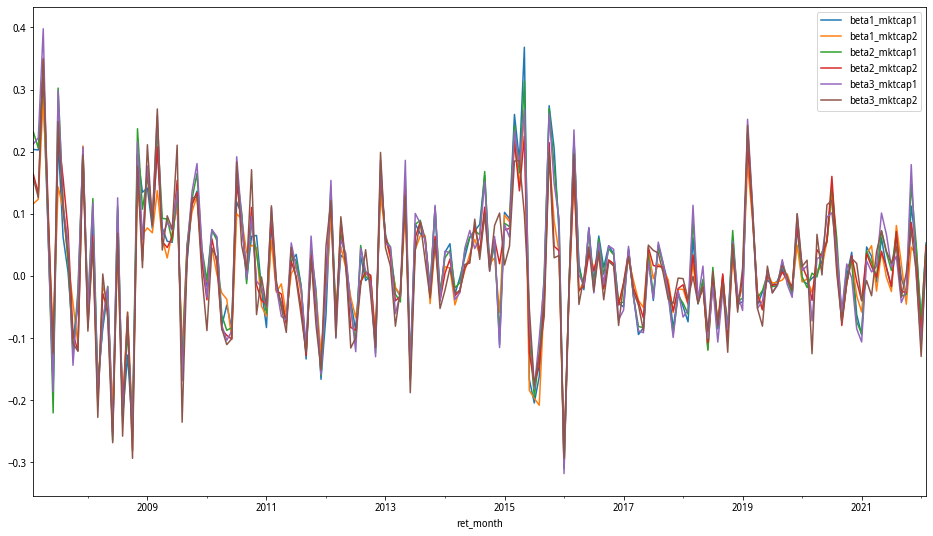

In [189]:
mean_portfolios_ret_df.plot()

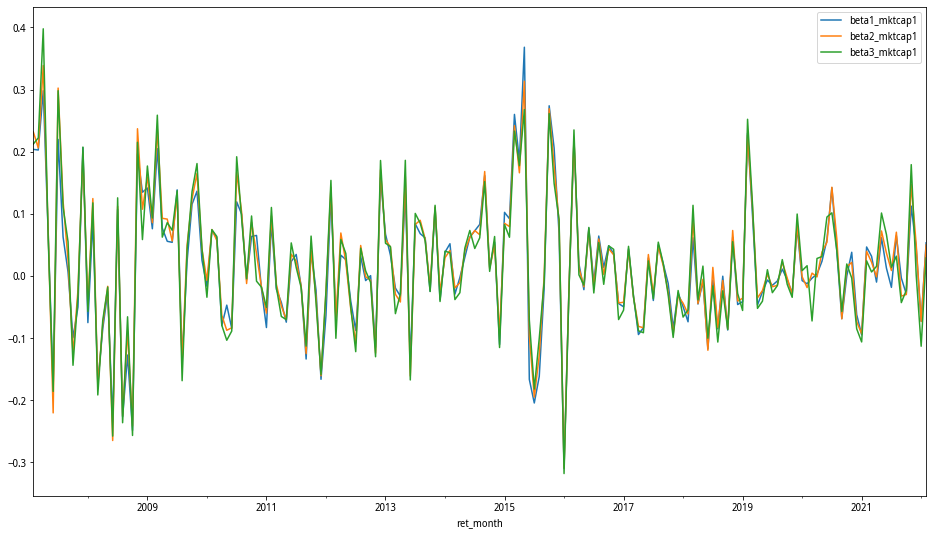

In [190]:
# Within mktcap1, any difference in beta groups?
pfs = mean_portfolios_ret_df.columns
cols = list(pfs[pfs.str[-7:] == 'mktcap1'])
mean_portfolios_ret_df[cols].plot()

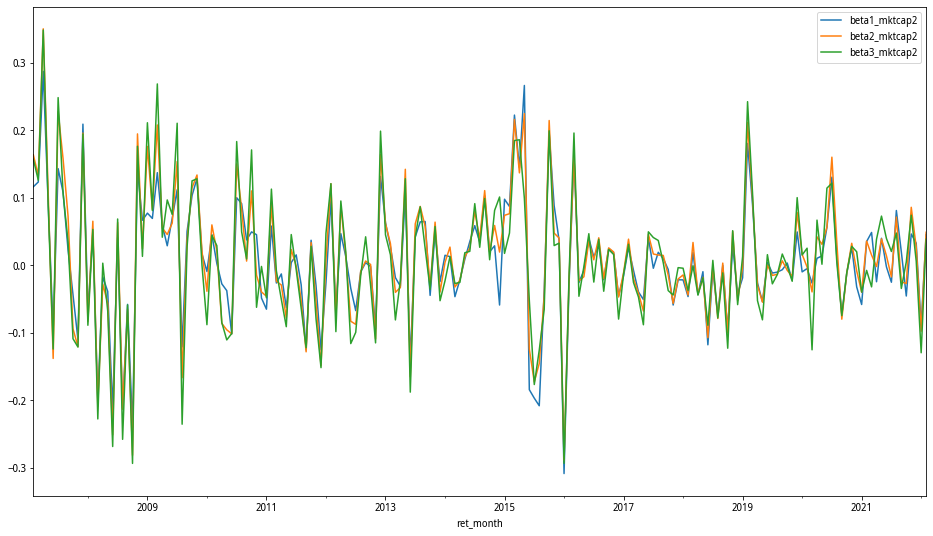

In [191]:
pfs = mean_portfolios_ret_df.columns
cols = list(pfs[pfs.str[-7:] == 'mktcap2'])
mean_portfolios_ret_df[cols].plot()

没有明显区别。下面看看在beta组内，不同的market cap有没有什么区别

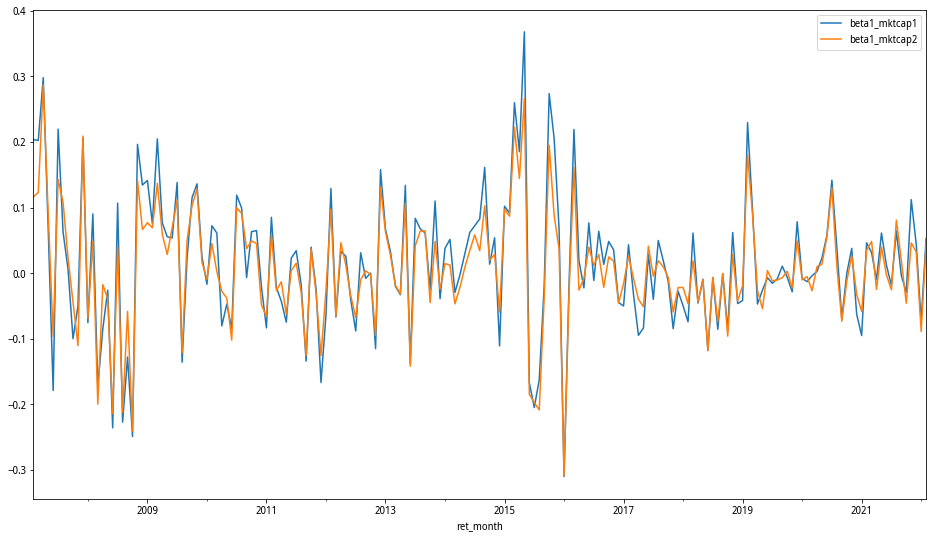

In [192]:
# Within beta1, any difference in mktcap groups?
pfs = mean_portfolios_ret_df.columns
cols = list(pfs[pfs.str[:5] == 'beta1'])
mean_portfolios_ret_df[cols].plot()

小盘股上涨多，下跌也多

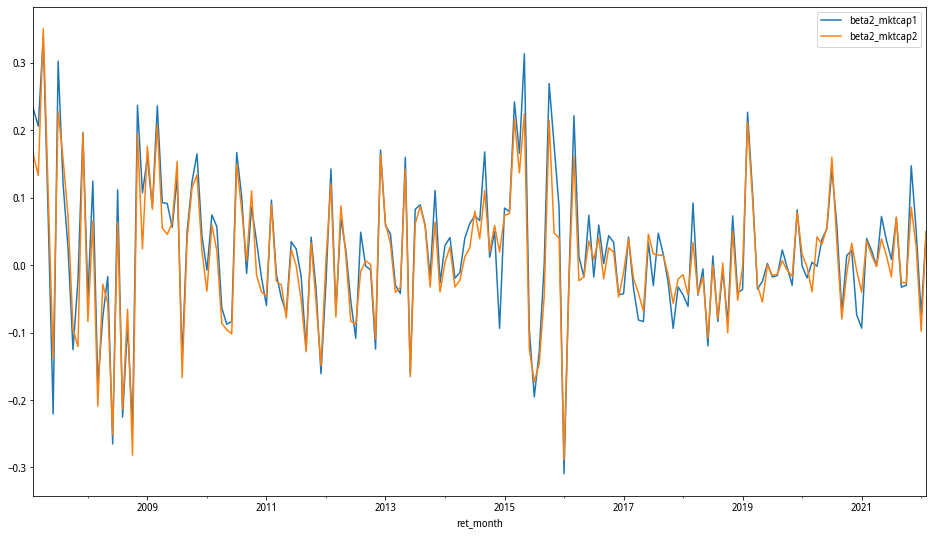

In [193]:
pfs = mean_portfolios_ret_df.columns
cols = list(pfs[pfs.str[:5] == 'beta2'])
mean_portfolios_ret_df[cols].plot()

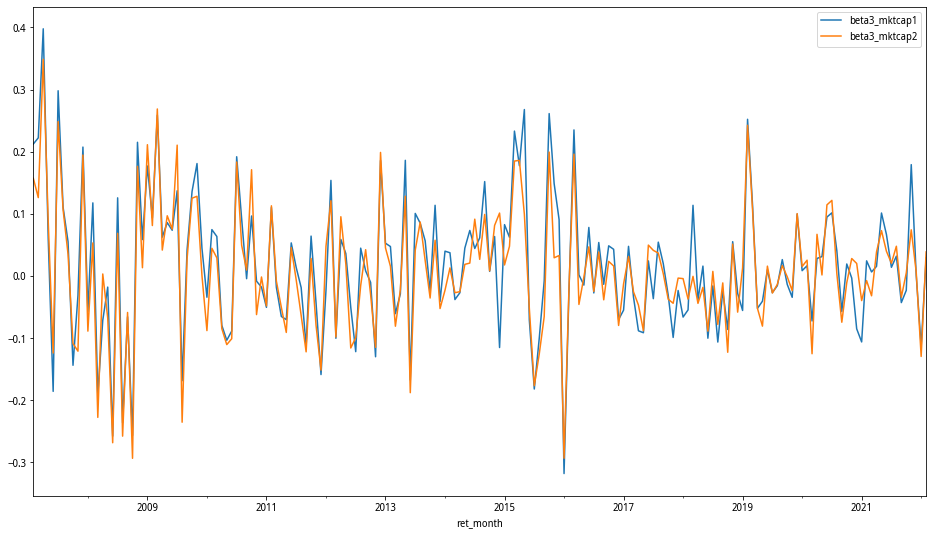

In [194]:
pfs = mean_portfolios_ret_df.columns
cols = list(pfs[pfs.str[:5] == 'beta3'])
mean_portfolios_ret_df[cols].plot()

In [195]:
# Newey-West adjustment
mean_values = {}
t_values = {}
for k in mean_portfolios_ret.keys():
    y = mean_portfolios_ret[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=4)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]

In [196]:
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

beta1_mktcap1  beta1_mktcap2  beta2_mktcap1  beta2_mktcap2  \
ret_mean       0.014987       0.006358       0.019496       0.010442   
t_values       1.811045       0.902366       2.310519       1.309309   

          beta3_mktcap1  beta3_mktcap2  
ret_mean       0.017265       0.007377  
t_values       2.009842       0.887556

### Beta, Market cap 双排结论

- Beta组内，小盘股平均收益高于大盘股
- 从图上看，小盘股上涨多，下跌也多

# Fama-MacBeth regression

In [197]:
ret_df['exret100'] = ret_df['exret'] * 100

In [198]:
def fm_reg(df):
    df_  = df.dropna()
    if df_.shape[0] < 15:
        return None
    reg = LinearRegression().fit(y=df_.loc[:,'exret'], X=df_.loc[:,['Beta252','size']])
    return np.insert(reg.coef_, 0, reg.intercept_)

## Without winsorization

In [199]:
temp = ret_df.groupby('ret_month').apply(fm_reg)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept', 'beta_coef', 'size_coef']

In [200]:
reg_result_df

intercept  beta_coef  size_coef
ret_month                                 
2007-02     0.449295   0.101046  -0.051140
2007-03     0.486338   0.066949  -0.052764
2007-04     0.310815   0.137880  -0.013632
2007-05    -0.063853  -0.013046   0.020593
2007-06    -0.468437  -0.090246   0.051264
2007-07     0.322566   0.157550  -0.033615
2007-08    -0.106563   0.060096   0.019636
2007-09    -0.129890   0.066064   0.012272
2007-10    -0.245085  -0.101635   0.031094
2007-11     0.285758   0.002528  -0.046270
...              ...        ...        ...
2021-05     0.172644   0.061018  -0.016368
2021-06     0.136382   0.075148  -0.016774
2021-07     0.072164   0.073526  -0.012521
2021-08     0.072283  -0.037762   0.000899
2021-09    -0.080184  -0.049619   0.009785
2021-10    -0.074396   0.034113   0.003911
2021-11     0.445675   0.055474  -0.042978
2021-12     0.073264  -0.008870  -0.004581
2022-01    -0.032456  -0.014668  -0.006358
2022-02     0.070991  -0.012546  -0.002123

[181 rows x 3 columns]

In [201]:
reg_result_df_ = reg_result_df.loc["2017":].copy()

In [202]:
reg_result_df_

intercept  beta_coef  size_coef
ret_month                                 
2017-01    -0.278234   0.001517   0.027824
2017-02     0.092141   0.006355  -0.007030
2017-03    -0.081923  -0.009977   0.007800
2017-04    -0.326956   0.008107   0.028863
2017-05    -0.239172  -0.010151   0.020233
2017-06    -0.041208   0.001161   0.009011
2017-07    -0.282004   0.028955   0.028671
2017-08     0.168681   0.009168  -0.016474
2017-09     0.060612  -0.004300  -0.004973
2017-10    -0.045947  -0.031607   0.006280
...              ...        ...        ...
2021-05     0.172644   0.061018  -0.016368
2021-06     0.136382   0.075148  -0.016774
2021-07     0.072164   0.073526  -0.012521
2021-08     0.072283  -0.037762   0.000899
2021-09    -0.080184  -0.049619   0.009785
2021-10    -0.074396   0.034113   0.003911
2021-11     0.445675   0.055474  -0.042978
2021-12     0.073264  -0.008870  -0.004581
2022-01    -0.032456  -0.014668  -0.006358
2022-02     0.070991  -0.012546  -0.002123

[62 rows x 3 columns]

In [203]:
# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df_.columns:
    y = reg_result_df_[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]

In [204]:
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

intercept  beta_coef  size_coef
ret_mean  -0.013533   0.006209   0.001040
t_values  -0.644866   1.969898   0.523846

## With winsorization

In [205]:
winsor_top = ret_df.groupby(['ret_month'])[['Beta252','size']].quantile(0.995)
winsor_bottom = ret_df.groupby(['ret_month'])[['Beta252','size']].quantile(0.005)
winsor_top.columns = ['beta_q995','size_q995']
winsor_bottom.columns = ['beta_q005','size_q005']

ret_df_q = pd.merge(ret_df, winsor_top, on='ret_month')

ret_df_q = pd.merge(ret_df_q, winsor_bottom, on='ret_month')

ret_df_q.loc[ret_df_q['Beta252'] > ret_df_q['beta_q995'],'Beta252'] = ret_df_q['beta_q995']
ret_df_q.loc[ret_df_q['Beta252'] < ret_df_q['beta_q005'],'Beta252'] = ret_df_q['beta_q005']
ret_df_q.loc[ret_df_q['size'] > ret_df_q['size_q995'],'size'] = ret_df_q['size_q995']
ret_df_q.loc[ret_df_q['size'] < ret_df_q['size_q005'],'size'] = ret_df_q['size_q005']

In [206]:
ret_df_q

secID ret_month     exret group_month        mkt_cap  Beta252  \
0       000001.XSHE   2007-07  0.313877     2007-06   42661.167898   0.4614   
1       000002.XSHE   2007-07  0.477505     2007-06   93332.479948   1.1541   
2       000006.XSHE   2007-07  0.282520     2007-06    5443.212086   1.0607   
3       000012.XSHE   2007-07  0.253637     2007-06    5096.113844   1.2944   
4       000014.XSHE   2007-07  0.547459     2007-06    1470.027591   0.9626   
5       000016.XSHE   2007-07  0.160653     2007-06    2213.931060   1.1464   
6       000018.XSHE   2007-07  0.276978     2007-06     226.419277   1.1392   
7       000021.XSHE   2007-07  0.136982     2007-06    5315.984592   1.1945   
8       000022.XSHE   2007-07  0.095368     2007-06    2484.607570   0.7355   
9       000023.XSHE   2007-07  0.348274     2007-06     551.772130   1.3330   
...             ...       ...       ...         ...            ...      ...   
454428  601899.XSHG   2010-09  0.116373     2010-08   41112.285370   0.9049   
454429  601918.XSHG   2010-09 -0.022752     2010-08   12709.525306   1.3989   
454430  601919.XSHG   2010-09 -0.022287     2010-08   21434.016390   1.2138   
454431  601939.XSHG   2010-09 -0.019112     2010-08   42120.000000   0.6709   
454432  601958.XSHG   2010-09  0.203846     2010-08   11873.215224   1.4165   
454433  601988.XSHG   2010-09  0.000871     2010-08  592136.972764   0.5898   
454434  601989.XSHG   2010-09 -0.035674     2010-08   17855.250000   0.5208   
454435  601991.XSHG   2010-09 -0.010821     2010-08   58404.084000   0.7183   
454436  601998.XSHG   2010-09 -0.097995     2010-08  148731.686086   1.1555   
454437  601999.XSHG   2010-09 -0.000508     2010-08    1813.000000   0.9296   

             size   exret100  beta_q995  size_q995  beta_q005  size_q005  
0       10.661044  31.387730   1.499900  10.949186   0.103700   5.631873  
1       10.949186  47.750494   1.499900  10.949186   0.103700   5.631873  
2        8.602125  28.251985   1.499900  10.949186   0.103700   5.631873  
3        8.536234  25.363665   1.499900  10.949186   0.103700   5.631873  
4        7.293036  54.745902   1.499900  10.949186   0.103700   5.631873  
5        7.702525  16.065346   1.499900  10.949186   0.103700   5.631873  
6        5.631873  27.697804   1.499900  10.949186   0.103700   5.631873  
7        8.578474  13.698189   1.499900  10.949186   0.103700   5.631873  
8        7.817870   9.536835   1.499900  10.949186   0.103700   5.631873  
9        6.313135  34.827419   1.499900  10.949186   0.103700   5.631873  
...           ...        ...        ...        ...        ...        ...  
454428  10.624062  11.637312   1.545708  11.889083   0.473286   6.058215  
454429   9.450107  -2.275185   1.545708  11.889083   0.473286   6.058215  
454430   9.972734  -2.228656   1.545708  11.889083   0.473286   6.058215  
454431  10.648278  -1.911224   1.545708  11.889083   0.473286   6.058215  
454432   9.382040  20.384574   1.545708  11.889083   0.473286   6.058215  
454433  11.889083   0.087055   1.545708  11.889083   0.473286   6.058215  
454434   9.790053  -3.567437   1.545708  11.889083   0.473286   6.058215  
454435  10.975141  -1.082082   1.545708  11.889083   0.473286   6.058215  
454436  11.889083  -9.799466   1.545708  11.889083   0.473286   6.058215  
454437   7.502738  -0.050820   1.545708  11.889083   0.473286   6.058215  

[454438 rows x 12 columns]

In [207]:
temp = ret_df_q.groupby('ret_month').apply(fm_reg)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept', 'beta_coef', 'size_coef']

In [208]:
# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df.columns:
    y = reg_result_df[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]

In [209]:
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

intercept  beta_coef  size_coef
ret_mean   0.044267   0.005316  -0.004631
t_values   2.660739   1.249944  -2.834965

# 结论

样本：2007:01-2022:02, 全部A股

单排、双排、FM回归结论一致：
- 小市值股比大市值股表现更好
- Beta不同，横截面上股票收益率无明显差异